# Decision Trees and Ensembles for Hail Size Diagnosis

## David John Gagne II

* NSF National Center for Atmospheric Research*

November 12, 2025

# First Example: Hail Forecasting

* Large hail causes billions of dollars in property damage every year
* Advanced warning about hail may allow people to protect some property
* How to forecast hail?
  * Identify atmospheric conditions associated with large hail before storms form
  * When storms form, identify those containing hail
* Data sources:
  * **Soundings**, NWP model output, radar

# Python Libraries for Data Science
* Numpy: for fast array math and linear algebra
* pandas: enables fast and complex manipulations of tabular data
* xarray: pandas-like manipulation of 4D gridded data
* scikit-learn: contains implementations of many common machine learning models
* matplotlib: 2D visualization
* jupyter notebook: Interactive data processing and visualization

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.inspection import permutation_importance
from sklearn.calibration import calibration_curve
from datetime import datetime, timedelta
from IPython.display import Image
import os
%matplotlib inline

# Data: Sounding Analog Retrieval System (SARS)
* Database of soundings associated with large hail
* Created by the National Weather Service [Storm Prediction Center](http://www.spc.noaa.gov/publications/jewell/sars.pdf)
* Data from [SHARPpy](https://github.com/sharppy/SHARPpy) Python sounding visualization package
* Given a current sounding, find which soundings are close matches (analogs)
* Task: develop a machine learning version of SARS for Hail

![SHARPy](https://sharppy.github.io/SHARPpy/_images/gui.sharppy.png)

In [232]:
hail_data = pd.read_csv("sars_hail.txt", sep="\t")
print(hail_data.columns)
hail_objects = pd.read_csv("hail_objects.csv")
date_raob = np.vstack(hail_data["DATE/RAOB"].str.split(".").values)
date_list = [datetime.strptime(d, "%y%m%d%H") for d in date_raob[:, 0]]
date_list = [datetime(d.year-100, d.month, d.day) if d.year > 2016 else d for d in date_list]
dates = pd.DatetimeIndex(date_list)
hail_data["date"] = dates
hail_data["year"] = dates.year
hail_data["month"] = dates.month
hail_data["raob"] = date_raob[:, 1]

Index(['DATE/RAOB', 'ELEV', 'REPORT', 'MUCAPE', 'MUMR', '500TEMP', '300 T',
       '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3', 'SHIP', 'MODELb'],
      dtype='object')


In [3]:
hail_objects

Object  Size
0   Marble/Moth ball  0.50
1              Penny  0.75
2             Nickel  0.88
3            Quarter  1.00
4        Half Dollar  1.25
5          Ping pong  1.50
6          Golf ball  1.75
7       Hen egg/Lime  2.00
8        Tennis ball  2.50
9           Baseball  2.75
10     Apple/Tea Cup  3.00
11          Softball  4.00
12        Grapefruit  4.50

## Hail Report Biases
* Reports of hail diameter are collected from the public by the National Weather Service
* Observers are encouraged to measure the diameter of the hail
* But often size is estimated based on comparisons with common objects
* Result: under-reporting of size categories with no object

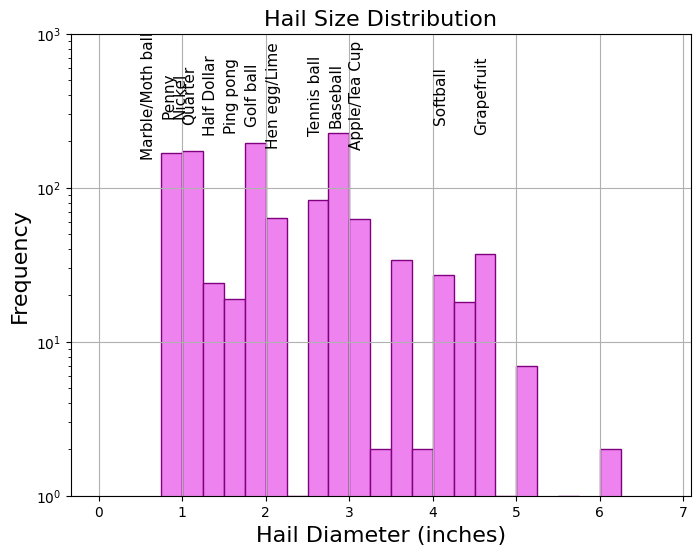

In [4]:
hail_data.hist("REPORT", bins=np.arange(0, 7, 0.25), figsize=(8, 6), color="violet", edgecolor="purple")
plt.ylim(1, 1000)
plt.xlabel("Hail Diameter (inches)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Hail Size Distribution", fontsize=16)
for r in hail_objects.index:
    plt.text(hail_objects.loc[r,"Size"], 400, hail_objects.loc[r,"Object"], 
             rotation=90, ha="left", va="center", fontsize=11)
ax = plt.gca()
ax.set_yscale("log")
plt.savefig("hail_size_dist.png", dpi=200, bbox_inches="tight")

# Hail Time Frequency
* Most SARS hail reports are from 1989-2009
* A few outlier cases in 1950s and 70s that were major hail events
* Most hail events fall between May and July
* Hail events from all months represented

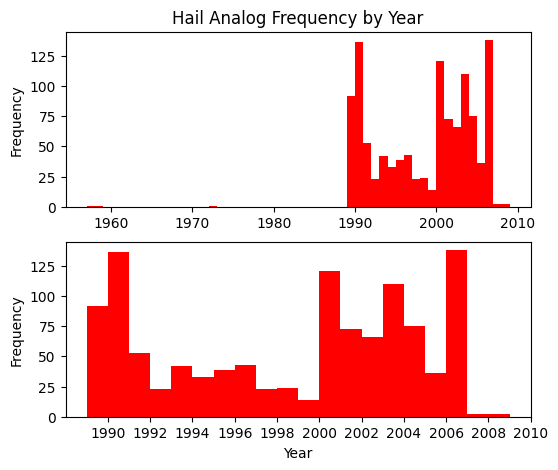

In [18]:

plt.figure(figsize=(6, 5))
plt.subplot(2,1,1)
plt.hist(hail_data["year"], bins=np.arange(1957, 2010), color="red")
plt.ylabel("Frequency")
plt.title("Hail Analog Frequency by Year")
plt.subplot(2,1,2)
plt.hist(hail_data["year"], bins=np.arange(1989, 2010), color="red")
plt.xticks(np.arange(1990, 2012, 2))
plt.xlabel("Year")
outtext = plt.ylabel("Frequency")


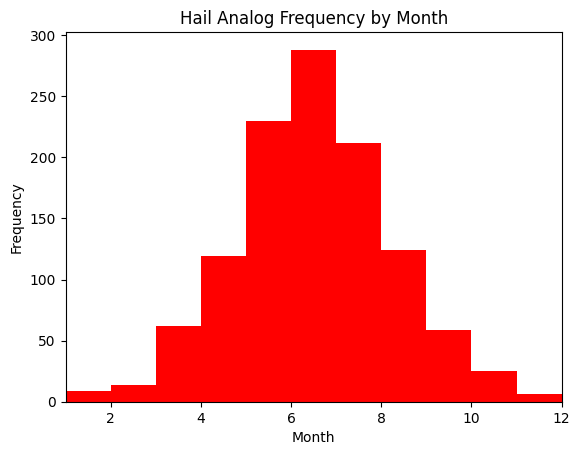

In [19]:
plt.hist(hail_data["month"], bins=np.arange(1, 13), color="red")
plt.xlim(1, 12)
plt.xlabel("Month")
plt.ylabel("Frequency")
outtext = plt.title("Hail Analog Frequency by Month")

In [10]:
hail_data

DATE/RAOB   ELEV  REPORT  MUCAPE  MUMR  500TEMP  300 T  7-5LR  \
0     95052300.DDC    791    6.00    4181  15.3     -9.6  -36.2    7.5   
1     91051100.MAF    873    6.00    4692  14.9    -10.8  -37.3    8.8   
2     97061700.OUN    357    5.50    5751  18.8     -9.5  -36.1    7.4   
3     99012200.LZK    165    5.00    2240  12.3    -17.3  -41.7    7.6   
4     96061200.DDC    791    5.00    2820  13.7     -8.3  -34.7    7.6   
...            ...    ...     ...     ...   ...      ...    ...    ...   
1143  97081700.TBW     13    0.75    3152  17.4     -7.3  -32.7    6.2   
1144  97081800.SLC   1288    0.75     931   8.3    -10.3  -36.9    8.5   
1145  97082200.ILN    317    0.75     520   9.6    -16.3  -41.3    5.8   
1146  98062500.JAN    101    0.75    3507  17.3     -6.1  -32.3    6.0   
1147  98081000.SHV     79    0.75    3464  16.8     -6.5  -33.5    5.9   

      5-3 LR  0-3SH  0-6SH  0-9SH  SRH3  SHIP  MODELb       date  year  month  \
0        7.1   23.4   19.4   26.8   325   1.9     3.0 1995-05-23  1995      5   
1        7.2   14.2   13.2   18.1   -37   1.9     2.7 1991-05-11  1991      5   
2        7.1   14.5   23.6   45.9   116   3.1     3.5 1997-06-17  1997      6   
3        6.8   23.0   26.3   32.1   294   2.3     3.0 1999-01-22  1999      1   
4        7.1   12.9   20.3   15.8   142   1.2     2.5 1996-06-12  1996      6   
...      ...    ...    ...    ...   ...   ...     ...        ...   ...    ...   
1143     6.8    1.8    2.6    4.4     8   0.3     0.6 1997-08-17  1997      8   
1144     7.2   13.6   16.1   22.9   203   0.3     1.4 1997-08-18  1997      8   
1145     6.9    3.9   17.5   30.9    50   0.2     0.7 1997-08-22  1997      8   
1146     7.0    7.1    2.3    8.6    -1   0.3     0.7 1998-06-25  1998      6   
1147     7.2    4.2    4.8    1.1    42   0.3     0.6 1998-08-10  1998      8   

     raob  
0     DDC  
1     MAF  
2     OUN  
3     LZK  
4     DDC  
...   ...  
1143  TBW  
1144  SLC  
1145  ILN  
1146  JAN  
1147  SHV  

[1148 rows x 19 columns]

<Axes: xlabel='year'>

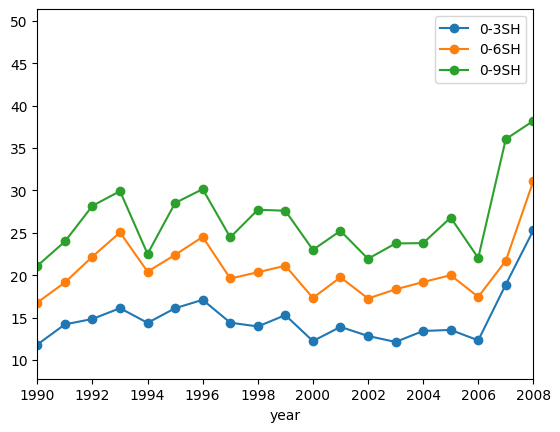

In [20]:
params = ["0-3SH", "0-6SH", "0-9SH"]
hail_data[["year"] + params].groupby("year").agg("mean").plot(y=params, 
                                            xlim=(1990, 2008), marker='o')

<Axes: xlabel='month'>

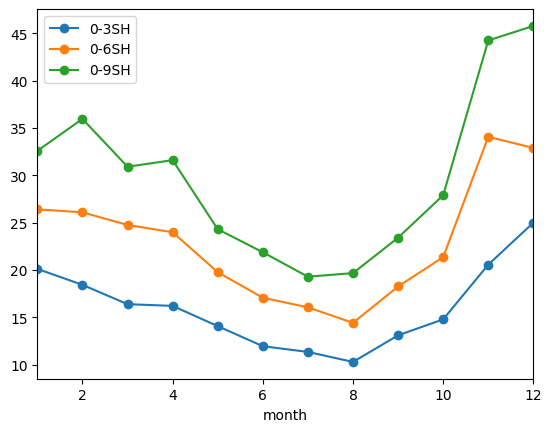

In [23]:
hail_data[["month"] + params].groupby("month").agg("mean").plot(y=params, 
                                            xlim=(1, 12), marker='o')

<Axes: xlabel='REPORT'>

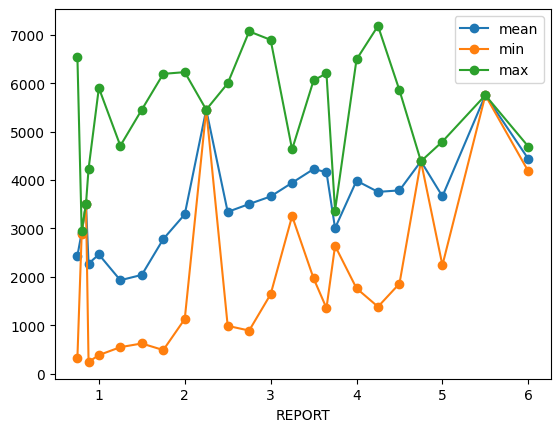

In [25]:
hail_data[["REPORT", "MUCAPE"]].groupby("REPORT").agg(["mean", "min", "max"]).plot(y="MUCAPE", marker="o")

# Hail Sounding Locations
* Most hail soundings come from Great Plains
* Dodge City, KS has most soundings
* Soundings from all over country

['ABQ' 'ABR' 'ALB' 'AMA' 'APX' 'BIS' 'BMX' 'BNA' 'BOI' 'BRO' 'BUF' 'CAR'
 'CHS' 'CRP' 'DDC' 'DNR' 'DRA' 'DRT' 'DTX' 'DVN' 'EPZ' 'FFC' 'FGZ' 'FWD'
 'GGW' 'GJT' 'GRB' 'GSO' 'GYX' 'IAD' 'ILN' 'ILX' 'INL' 'JAN' 'JAX' 'LBF'
 'LCH' 'LIX' 'LMN' 'LZK' 'MAF' 'MFL' 'MHX' 'MPX' 'NKX' 'OAK' 'OAX' 'OKX'
 'OTX' 'OUN' 'PIT' 'RAP' 'RNK' 'SGF' 'SHV' 'SLC' 'TBW' 'TFX' 'TLH' 'TOP'
 'TUS' 'WAL' 'XMR']


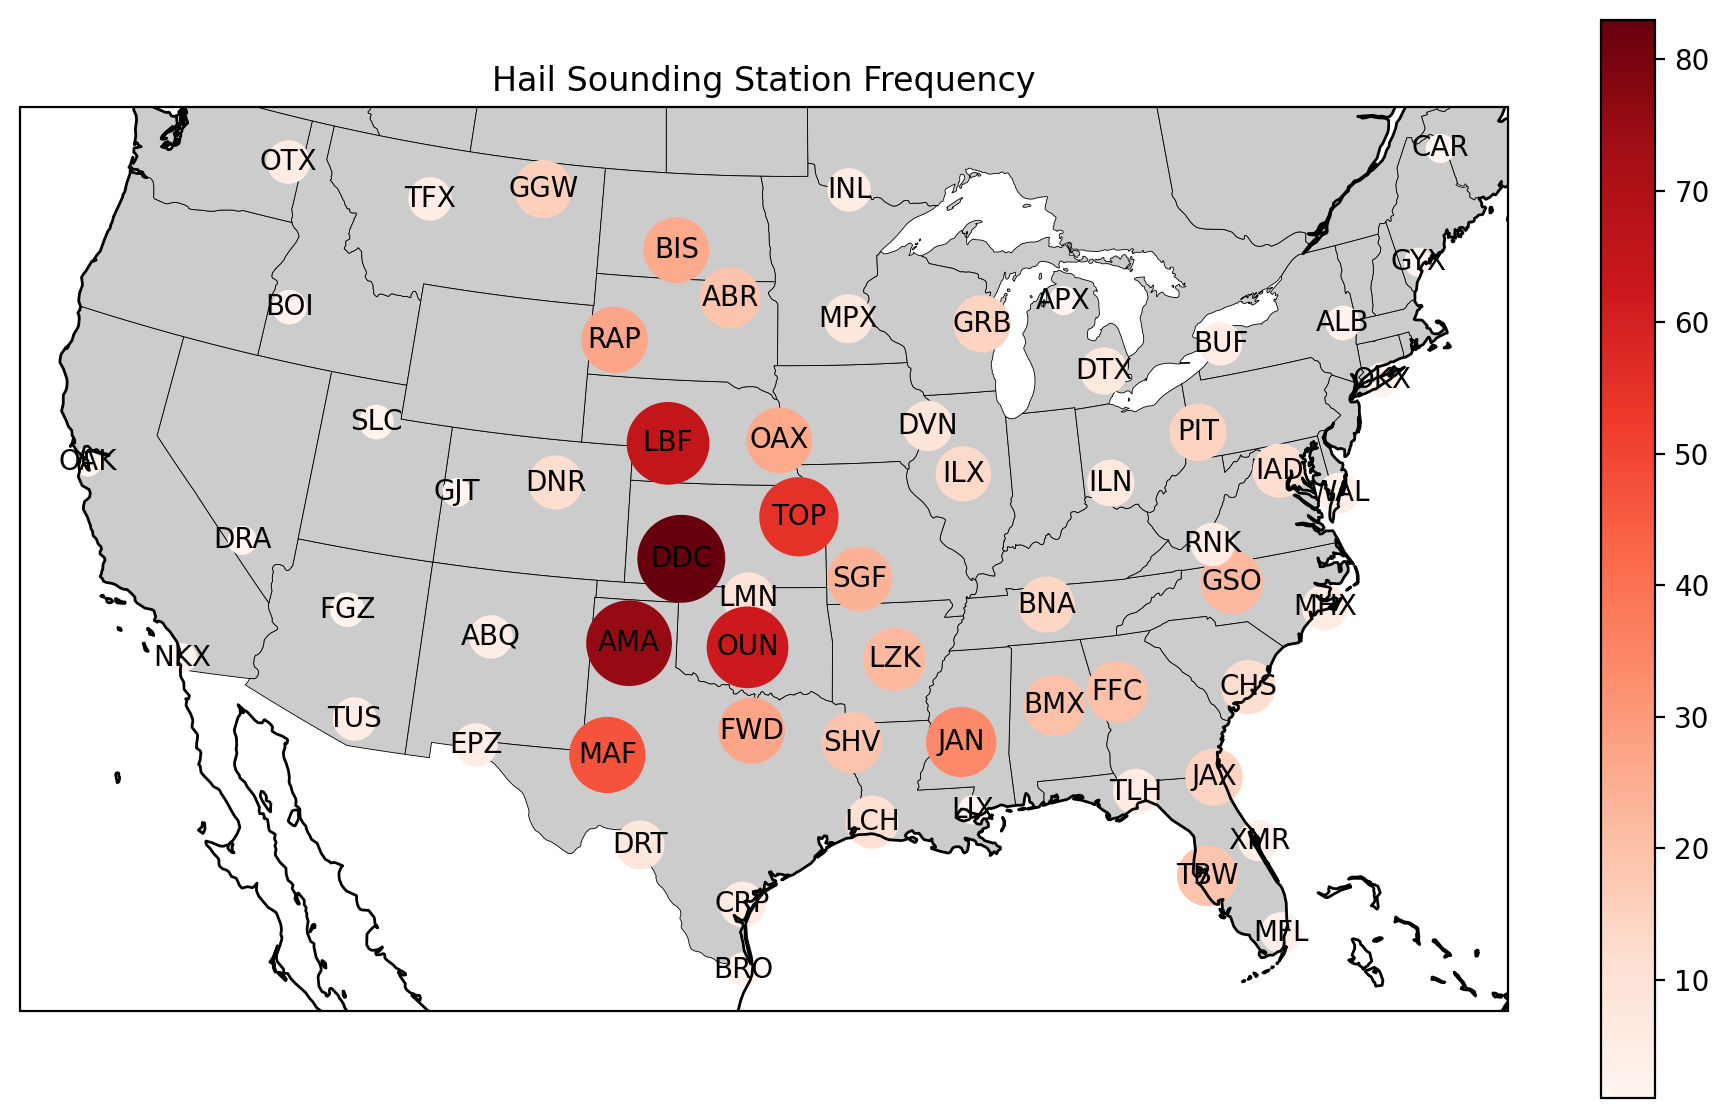

In [172]:
station_info = pd.read_csv("spc_ua.csv", index_col="iata")
stations = np.intersect1d(np.unique(hail_data["raob"]), station_info.index.dropna())
print(stations)
station_counts = np.zeros(stations.size)
for s, station in enumerate(stations):
    station_counts[s] =  np.count_nonzero(hail_data["raob"] == station)
fig, ax = plt.subplots(1, 1, figsize=(12, 7), dpi=200, subplot_kw=dict(projection=ccrs.LambertConformal()))
#ax.set_facecolor('lightgray')
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='k', facecolor='0.8', zorder=0)
sca = ax.scatter(station_info.loc[stations, "lon"], station_info.loc[stations, "lat"], 
            np.sqrt(station_counts) * 110, station_counts, cmap="Reds", edgecolor="none", transform=ccrs.PlateCarree())
for s, station in enumerate(stations):
    if station in station_info.index:
        plt.text(station_info.loc[station, "lon"], station_info.loc[station, "lat"], station, ha="center", va="center", transform=ccrs.PlateCarree())
ax.set_title("Hail Sounding Station Frequency")
cbar = plt.colorbar(sca)
plt.savefig("hail_sounding_stations.png", dpi=300, bbox_inches="tight")

# Evaluation Procedure
* Predict probability of hail diameter > 2 inches
* Defined as significant severe hail by SPC 
* Generally causes damage to cars, roofs, and crops
* Split data randomly into training and testing sets

In [234]:
train = hail_data.sample(frac=0.7, random_state=404)
test = hail_data.drop(train.index)

# Machine Learning Models
* Seek balance between accuracy and interpretability
* SARS: Analog (nearest neighbor) method
  * Finds hail soundings with closest proximity to input sounding and determines what percentage have significant hail
* Logistic Regression: probabilistic linear regression
  * Fits linear weights to input variables then uses logit function to transform results into 0-1 range
* Decision Tree
  * Recursively partitions training data into more similar subsets and determines probability from relative frequency in each subset
* Random Forest
  * Ensemble of randomized decision trees

In [235]:
input_cols = np.array(['MUCAPE', 'MUMR', '500TEMP', '300 T', '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3'])
test_col = "REPORT"
size_threshold = 2
models = [RandomForestClassifier(n_estimators=100, max_features="sqrt"),
          DecisionTreeClassifier(max_depth=3),
         LogisticRegression(penalty="l1", solver="liblinear", C=0.01)]
model_names = np.array(["Random Forest",
                        "Decision Tree",
                        "Logistic Regression"])
hail_class_label = np.where(train[test_col] >= size_threshold, 1, 0)
for model in models:
    model.fit(train[input_cols], hail_class_label)


# Scikit-Learn Modeling Procedure
1. Initialize model object with model parameters
2. Call fit function of model object and pass training data
3. Call predict_proba function to get probabilities of each class

# Decision Tree Interpretation
* Bluer nodes have higher hail probabilities
* Nodes near top of tree have larger impact on predictions
* Shear and CAPE related variables near top of tree

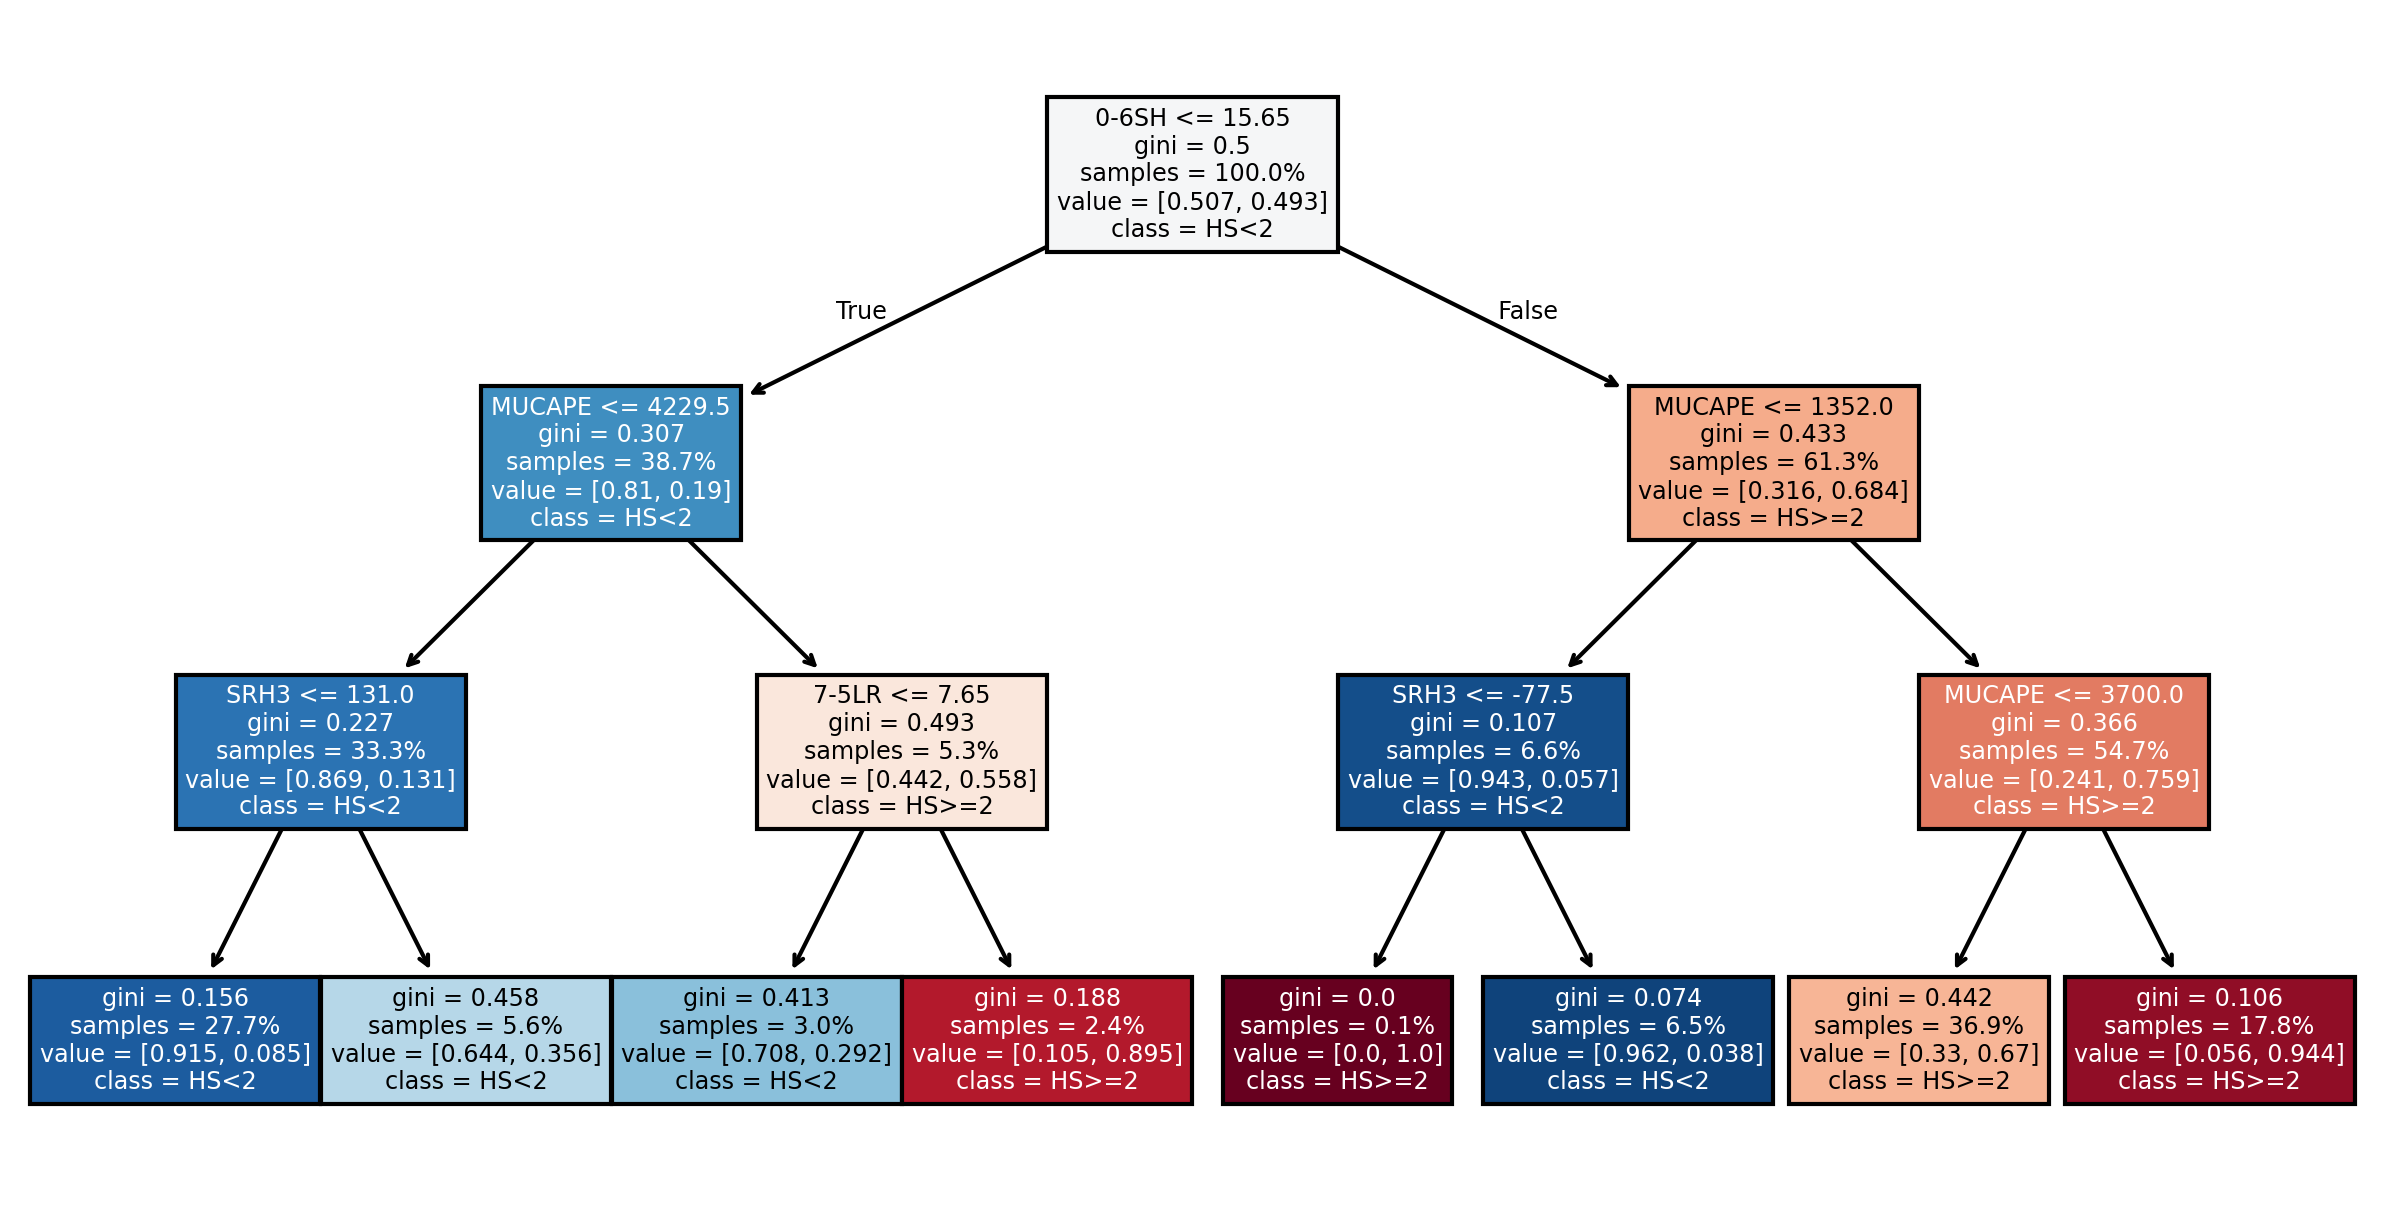

In [205]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
text_boxes = plot_tree(models[1], feature_names=input_cols, class_names=["HS<2", "HS>=2"], proportion=True, ax=ax)
cmap = plt.get_cmap("RdBu_r")
for box in text_boxes:
    box_text_list = box.get_text().split("\n")
    if len(box_text_list) > 1:
        hail_prob = float(box_text_list[-2].split(",")[-1][:-1])
        box.get_bbox_patch().set_facecolor(cmap(hail_prob))
        if hail_prob <= 0.25 or hail_prob >= 0.75: 
            box.set_color("w")
plt.savefig("big_hail_tree.png", dpi=300, bbox_inches="tight")

# Random Forest Feature Importance
* Random forest contains many decision trees, so individual trees are hard to interpret.
* Feature importance scores provide a summary measure of how much each input influences predictions in bulk.
* Mean decrease in impurity score for a given variable: $\sum_{n=1}^{N}s_{nt} g_{nt}-(s_{lt} g_{lt} + s_{rt} g_{rt})$
* Permutation importance measures the decrease in performance by shuffling the values of an input across examples.
* Impurity importance is derived from the trees directly while permutation importance is model-agnostic and can be re-run on different subsets of the data.

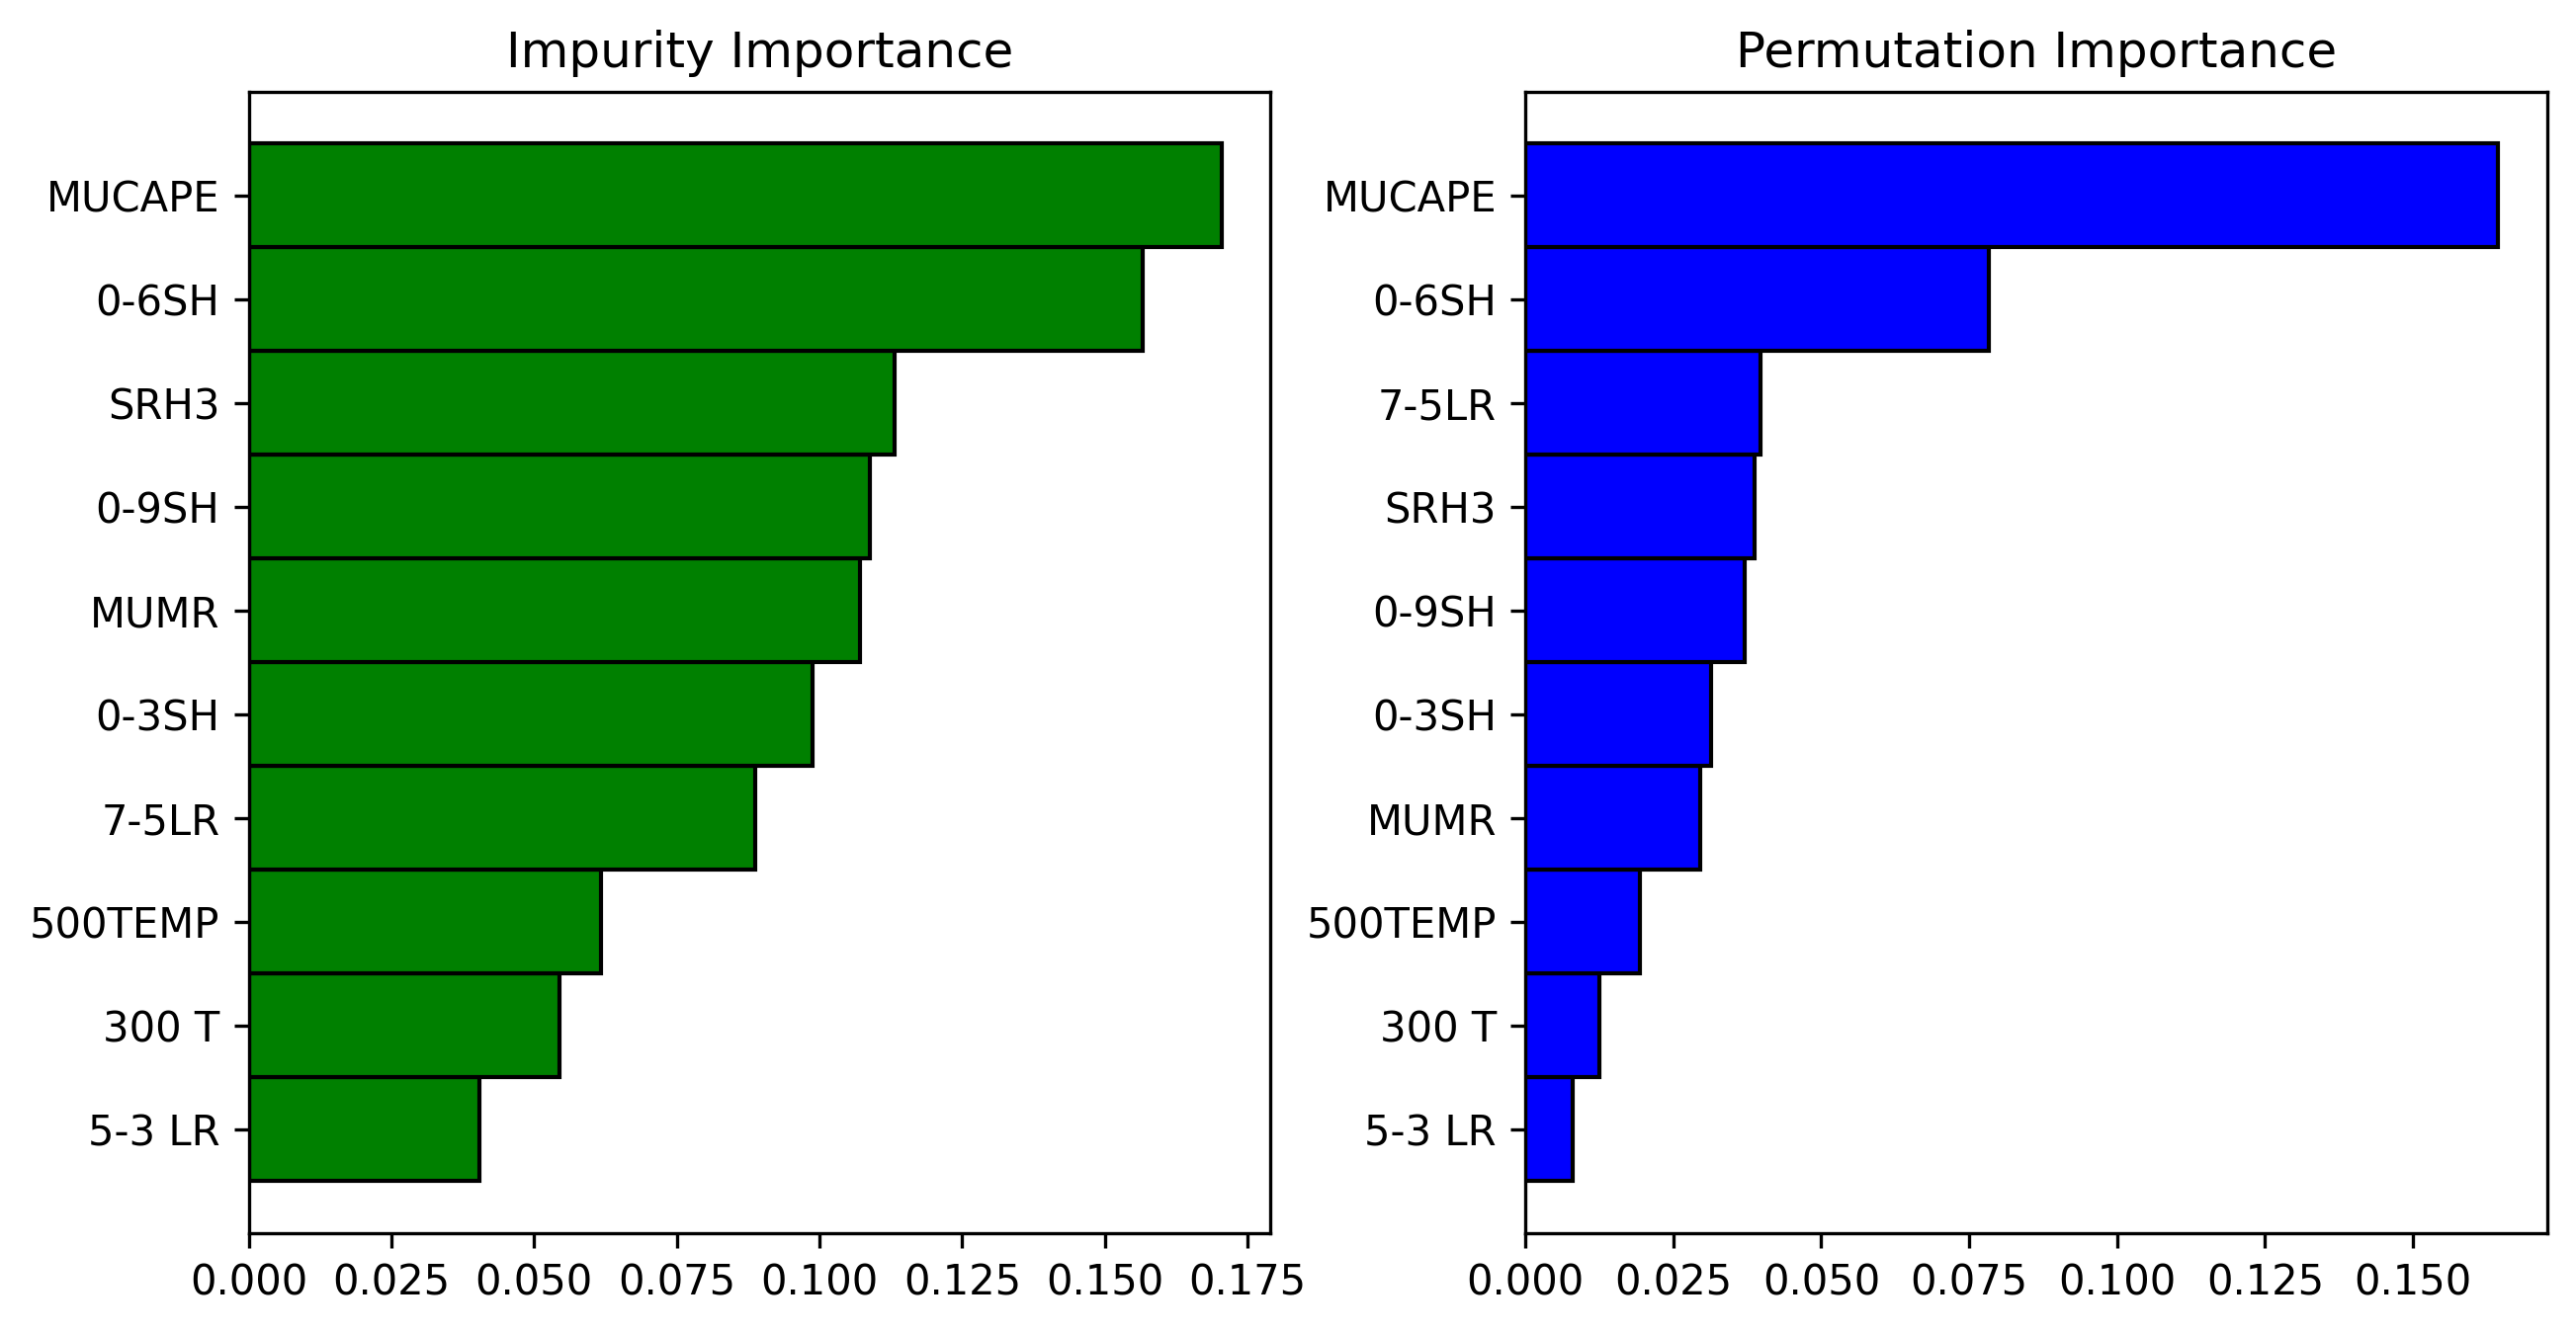

In [222]:
feature_ranking = models[0].feature_importances_.argsort()
perm_scores = permutation_importance(models[0], train[input_cols], 
                                     np.where(train[test_col] >= size_threshold, 1, 0))
perm_ranking = perm_scores["importances_mean"].argsort()
plt.figure(figsize=(10, 5), dpi=300)
plt.subplots_adjust(wspace=0.25)
plt.subplot(1, 2, 1)
plt.barh(np.arange(feature_ranking.size) + 0.5, models[0].feature_importances_[feature_ranking], 1, color="green", ec='k')
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[feature_ranking])
plt.title("Impurity Importance")
plt.subplot(1, 2, 2)
plt.barh(np.arange(feature_ranking.size) + 0.5, perm_scores["importances_mean"][perm_ranking], 1, 
         color="blue", edgecolor='k')
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[perm_ranking])
plt.title("Permutation Importance")
plt.savefig("importance_comp.png", dpi=300, bbox_inches="tight")

(array([242., 277.,  22., 156.,  45.,  36.,   0.,  24.,   0.,   2.]),
 array([   3. ,  221.9,  440.8,  659.7,  878.6, 1097.5, 1316.4, 1535.3,
        1754.2, 1973.1, 2192. ]),
 <BarContainer object of 10 artists>)

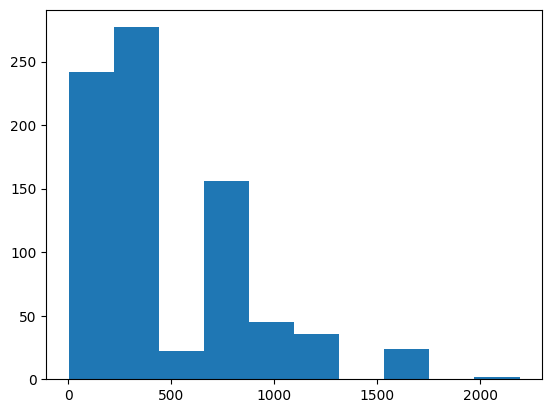

In [236]:
plt.hist(train["ELEV"])

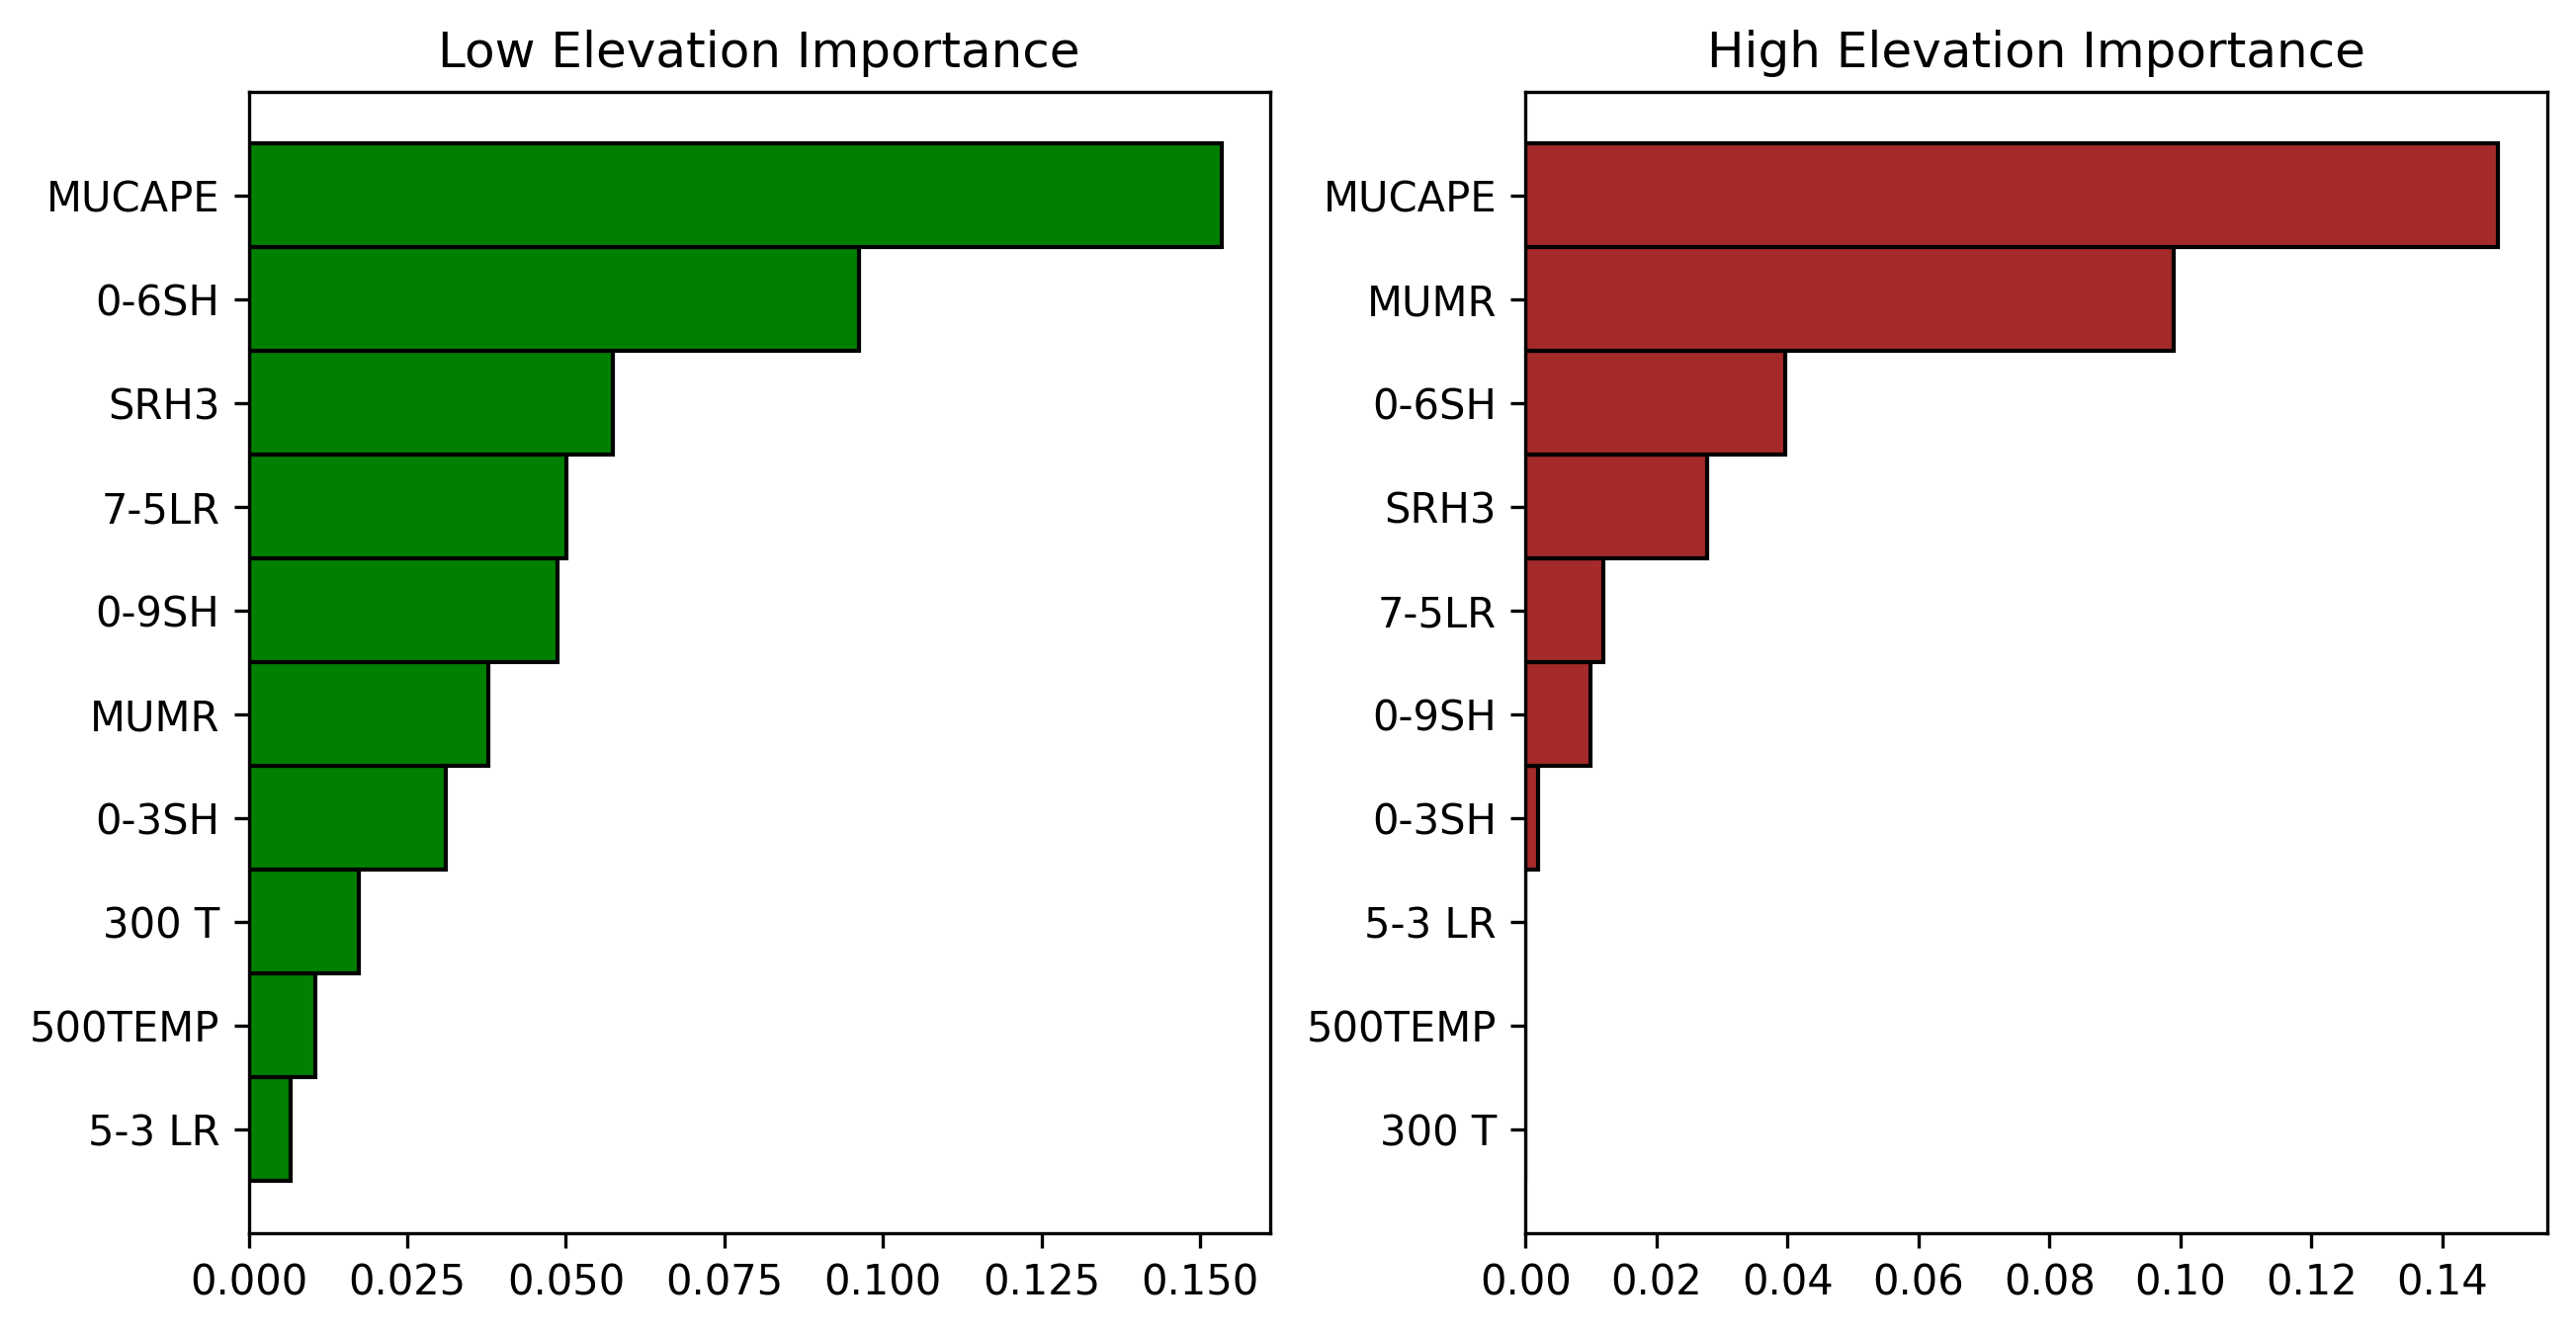

In [240]:
low_elev = train["ELEV"] < 1000
high_elev = train["ELEV"] >= 1000
low_perm_scores = permutation_importance(models[0], train.loc[low_elev, input_cols], 
                                     hail_class_label[low_elev])
low_perm_ranking = low_perm_scores["importances_mean"].argsort()
high_perm_scores = permutation_importance(models[0], train.loc[high_elev, input_cols], 
                                     hail_class_label[high_elev])
high_perm_ranking = high_perm_scores["importances_mean"].argsort()
plt.figure(figsize=(10, 5), dpi=300)
plt.subplots_adjust(wspace=0.25)
plt.subplot(1, 2, 1)
plt.barh(np.arange(low_perm_ranking.size) + 0.5, low_perm_scores["importances_mean"][low_perm_ranking], 
         1, color="green", ec='k')
plt.yticks(np.arange(low_perm_ranking.size) + 0.5, input_cols[low_perm_ranking])
plt.title("Low Elevation Importance")
plt.subplot(1, 2, 2)
plt.barh(np.arange(high_perm_ranking.size) + 0.5, high_perm_scores["importances_mean"][high_perm_ranking], 1, 
         color="brown", edgecolor='k')
plt.yticks(np.arange(high_perm_ranking.size) + 0.5, input_cols[high_perm_ranking])
plt.title("High Elevation Importance")
plt.savefig("elev_importance_comp.png", dpi=300, bbox_inches="tight")

<Axes: >

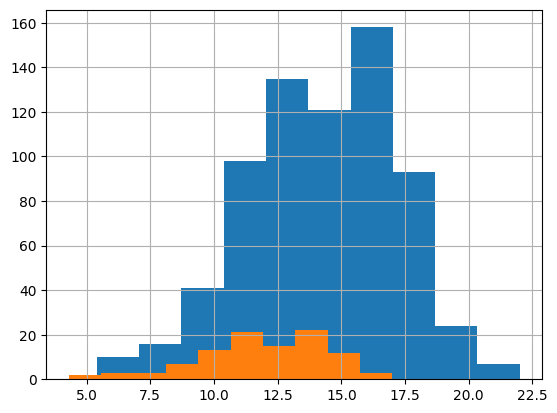

In [243]:
train.loc[low_elev, "MUMR"].hist()
train.loc[high_elev, "MUMR"].hist()

# Logistic Regression Coefficients
* Most Unstable Mixing Ratio, 500 mb Temperature, and 700-500/500-300 mb Lapse Rates have negative coefficients

In [85]:
for i, input_name in enumerate(input_cols):
    print(input_name, models[2].coef_[0,i])

MUCAPE 0.0011499676948785414
MUMR -0.23864530966571643
500TEMP 0.0
300 T 0.07264989336372452
7-5LR 0.0
5-3 LR 0.0
0-3SH 0.02726199245145937
0-6SH 0.06937190318396613
0-9SH 0.02947054238343414
SRH3 0.001982799232260446


In [86]:
def hail(hail_database, size_threshold, mumr, mucape, h5_temp, lr, shr6, shr9, shr3, srh):
    '''
    The SARS Hail database was provided by Ryan Jewell of the NOAA Storm
    Prediction Center in Norman, Oklahoma. This is a database of observed
    and model proximity analogue soundings to hail events.
    
    This function works by searching for matches to particular variables in 
    the database that have been attributed to hail events given a certain 
    range of uncertainty. The loose matches are used for statistics such as
    % significant hail matches, and are based on a looser criteria for
    matches. The analogues that get displayed are based on a tighter criteria
    for matches to insure that only quality matches are received. Ranges for
    loose and quality matches are semi-arbitrary, and were tuned by testing
    internally by SPC.
    
    The loose matches are based on the most unstable parcel mixing ratio (mumr),
    most unstable cape (mucape), 700-500mb labse rate (lr), 500mb temperature
    (h5_temp), 0-3km shear (shr3), 0-6km shear (shr6), and the 0-9km shear (shr9).
    
    The ranges for the loose matches are set as such:
        mumr: +/- 2.0 g/kg
        mucape: +/- 30% J/kg
        lr: +/- 2.0 C/km
        h5_temp: +/- 9.0 C
        shr6: +/- 12 m^2/s^2
        shr9: +/- 22 m^2/s^2
        shr3: +/- 10 m^2/s^2
    
    The quality matches use the fields described in the loose matches, plus the
    0-3km Storm Relative Helicity (srh). The bounds for the search for quality 
    matches is much more strict that the loose matches.
    
    The ranges for the quality matches are set as such:
        mumr: +/- 2.0 g/kg
        mucape < 500 J/kg: +/- 50% J/kg
        mucape < 2000 J/kg: +/- 25% J/kg
        mucape >= 2000 J/kg: +/- 20% J/kg
        lr: +/- 0.4 C/km
        h5_temp: +/- 1.5 C/km
        shr6: +/- 6 m^2/s^2
        shr9: +/- 15 m^2/s^2
        shr3: +/- 8 m^2/s^2
        srh < 50 m^2/s^2: +/- 25 m^2/s^2
        srh >= 50 m^2/s^2: +/- 50% m^2/s^2
    
    Parameters
    ----------
    mumr - most unstable parcel mixing ratio (g/kg)
    mucape - most unstable CAPE (J/kg)
    h5_temp - 500 mb temperature (C)
    lr - 700-500 mb lapse rate (C/km)
    shr6 - 0-6 km shear (m/s)
    shr9 - 0-9 km shear (m/s)
    shr3 - 0-3 km shear (m/s)
    srh - 0-3 Storm Relative Helicity (m2/s2)
    
    Returns
    -------
    quality_match_dates (str) - dates of the quality matches
    quality_match_sizes (float) - hail sizes of the quality matches
    num_loose_matches (int) - number of loose matches
    num_sig_reports (int) - number of significant hail reports (>= 2 inches)
    prob_sig_hail (float) - SARS sig. hail probability
    
    '''
    ## open the file in the current directory with the name database_fn

    #Set range criteria for matching sounding
    # MU Mixing Ratio Ranges
    range_mumr = 2.0 # g/kg
    range_mumr_t1 = 2.0 # g/kg

    # MUCAPE Ranges (J/kg)
    range_mucape = mucape*.30
    if mucape < 500.:
        range_mucape_t1 = mucape * .50
    elif mucape >= 500. and mucape < 2000.:
        range_mucape_t1 = mucape * .25
    else:
        range_mucape_t1 = mucape * .20

    # 700-500 mb Lapse Rate Ranges
    range_lr = 2.0 # C/km
    range_lr_t1 = 0.4 # C/km

    # 500 mb temperature ranges
    range_temp = 9 # C
    range_temp_t1 = 1.5 # C

    # 0-6 km shear ranges
    range_shr6 = 12 # m/s
    range_shr6_t1 = 6 # m/s

    # 0-9 km shear ranges

    range_shr9 = 22 # m/s
    range_shr9_t1 = 15 # m/s

    # 0-3 km shear ranges
    range_shr3 = 10
    range_shr3_t1 = 8

    # 0-3 SRH Ranges
    range_srh = 100
    if srh < 50:
        range_srh_t1 = 25
    else:
        range_srh_t1 = srh * 0.5

    #Get database variables from the columns in the file and make them floats
    matmr = np.asarray(hail_database[:,4], dtype=float) # MU Mixing Ratio
    matcape = np.asarray(hail_database[:,3], dtype=float) # MUCAPE
    matlr = np.asarray(hail_database[:,7], dtype=float) # 700-500 mb lapse rate
    mattemp = np.asarray(hail_database[:,5], dtype=float) # 500 mb temp
    matshr6 = np.asarray(hail_database[:,10], dtype=float) # 0-6 shear
    matshr9 = np.asarray(hail_database[:,11], dtype=float) # 0-9 shear
    matshr3 = np.asarray(hail_database[:,9], dtype=float) # 0-3 shear
    matsrh = np.asarray(hail_database[:,12], dtype=float) # 0-3 SRH

    # Find the loose matches using the ranges set above
    loose_match_idx = np.where((mumr >= (matmr - range_mumr)) & (mumr <= (matmr + range_mumr)) & \
                               (mucape >= (matcape - range_mucape)) & (mucape <= (matcape + range_mucape)) & \
                               (lr >= (matlr - range_lr)) & (lr <= (matlr + range_lr)) & \
                               (h5_temp >= (mattemp - range_temp)) & (h5_temp <= (mattemp + range_temp)) & \
                               (shr6 >= (matshr6 - range_shr6)) & (shr6 <= (matshr6 + range_shr6)) & \
                               (shr9 >= (matshr9 - range_shr9)) & (shr9 <= (matshr9 + range_shr9)) & \
                               (shr3 >= (matshr3 - range_shr3)) & (shr3 <= (matshr3 + range_shr3)))[0]
    ## How many loose matches are there?
    num_loose_matches = float(len(loose_match_idx))
    ## What were the sizes of those matches?
    hail_sizes = np.asarray(hail_database[:,2], dtype=float)
    ## How many of them were significant (>2.0 in)?
    num_sig_reports = float(len(np.where(hail_sizes[loose_match_idx] >= size_threshold)[0]))

    ## Calculate the Probability of significant hail - must make sure
    ## loose matches are > 0 to prevent division by 0.
    if num_loose_matches > 0 and mucape > 0:
        prob_sig_hail = num_sig_reports / num_loose_matches
        # Calculate the average hail size from the loose matches
        avg_hail_size = np.mean(hail_sizes[loose_match_idx])
    else:
        prob_sig_hail = 0
        avg_hail_size = 0
    # Find the quality matches
    quality_match_idx = np.where((mumr >= (matmr - range_mumr_t1)) & (mumr <= (matmr + range_mumr_t1)) & \
                               (mucape >= (matcape - range_mucape_t1)) & (mucape <= (matcape + range_mucape_t1)) & \
                               (lr >= (matlr - range_lr_t1)) & (lr <= (matlr + range_lr_t1)) & \
                               (h5_temp >= (mattemp - range_temp_t1)) & (h5_temp <= (mattemp + range_temp_t1)) & \
                               (shr6 >= (matshr6 - range_shr6_t1)) & (shr6 <= (matshr6 + range_shr6_t1)) & \
                               (shr9 >= (matshr9 - range_shr9_t1)) & (shr9 <= (matshr9 + range_shr9_t1)) & \
                               (shr3 >= (matshr3 - range_shr3_t1)) & (shr3 <= (matshr3 + range_shr3_t1)) & \
                               (srh >= (matsrh - range_srh_t1)) & (srh <= (matsrh + range_srh_t1)))[0]

    quality_match_dates = hail_database[quality_match_idx,0]
    quality_match_sizes = np.asarray(hail_database[quality_match_idx,2], dtype=float)

    # This filtering was in the sars.f file so the graphical output wasn't overrun by historical quality matches
    max_quality_matches = 15
    quality_match_dates = quality_match_dates[:max_quality_matches]
    quality_match_sizes = quality_match_sizes[:max_quality_matches]

    return quality_match_dates, quality_match_sizes, num_loose_matches, num_sig_reports, avg_hail_size, prob_sig_hail

In [93]:
test.columns

Index(['DATE/RAOB', ' ELEV', 'REPORT', 'MUCAPE', 'MUMR', '500TEMP', '300 T',
       '7-5LR', '5-3 LR', '0-3SH', '0-6SH', '0-9SH', 'SRH3', 'SHIP', 'MODELb',
       'date', 'year', 'month', 'raob'],
      dtype='object')

In [99]:
train_text = train.astype("str").values
# Input args: mumr, mucape, h5_temp, lr, shr6, shr9, shr3, srh
sars_test_probs = np.zeros(test.shape[0])
sars_hail_sizes = np.zeros(test.shape[0])
for r, row in enumerate(test.index):
    sars_hail_sizes[r], sars_test_probs[r] = hail(train_text, size_threshold, *test.loc[row, ["MUMR", "MUCAPE", "500TEMP", "7-5LR", "0-6SH", "0-9SH", "0-3SH", "SRH3"]].tolist())[-2:]

# Evaluation
* Receiver Operator Characteristic (ROC) Curve
  * Measures how well a model can discriminate between two outcomes
  * Calculates binary contingency table (confusion matrix) at different probability thresholds
  * Probability of Detection (Y-axis): $\frac{TP}{TP+FN}$
  * Probability of False Detection (X-axis): $\frac{FP}{FP+TN}$
  * Area Under the ROC Curve (AUC): 1 is perfect, 0.5 is no skill above random chance
* Reliability Diagram
  * Plot of forecast probability versus the observed relative frequency of forecasts with a certain probability
  * Want observed relative frequency to match forecast probability
  * Below diagonal is overforecast bias, above diagonal is under forecast bias
  * Sharpness, or the variance of the forecasts, can also be inferred from the reliability diagram
  * Brier score: mean squared error of the probability forecasts, smaller is better

Text(0.5, 1.0, 'Hail > 2 inches Reliability Diagram')

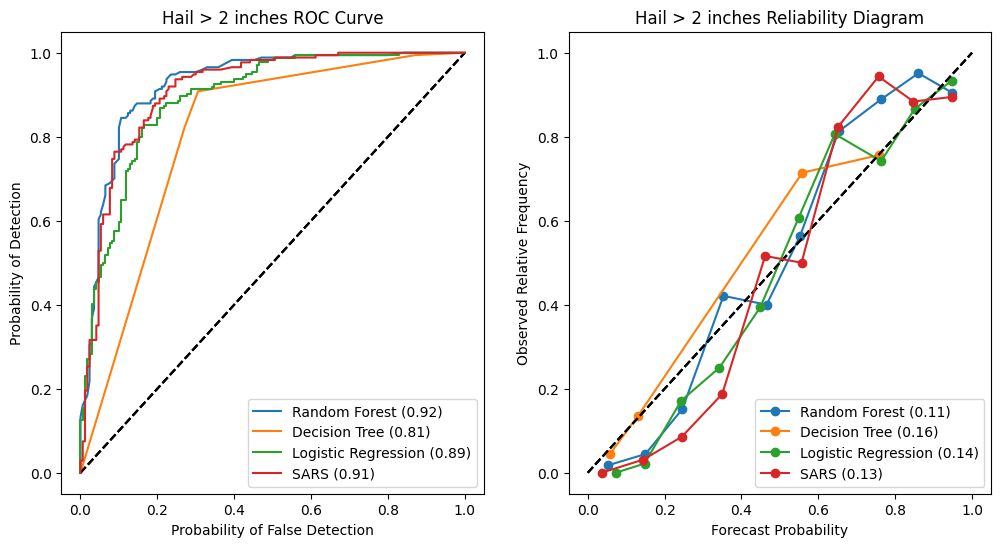

In [100]:
test_results = pd.DataFrame(columns=model_names, index=test.index, dtype=float)
test_labels = np.where(test[test_col] >= size_threshold, 1, 0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
for m, model in enumerate(models):
    test_results[model_names[m]] = model.predict_proba(test[input_cols])[:, 1]
    pofd, pod, prob_thresh = roc_curve(test_labels, test_results[model_names[m]], pos_label=1)
    auc = roc_auc_score(test_labels, test_results[model_names[m]])
    prob_true, prob_pred = calibration_curve(test_labels, test_results[model_names[m]], n_bins=10)
    brier_score = brier_score_loss(test_labels, test_results[model_names[m]])
    ax1.plot(pofd, pod, label=model_names[m] + " ({0:0.2f})".format(auc))
    ax2.plot(prob_pred, prob_true, marker='o', label=model_names[m] + " ({0:0.2f})".format(brier_score))
    ax1.plot(np.arange(0, 1.1, .1),np.arange(0, 1.1, .1), 'k--')
    ax2.plot(np.arange(0, 1.1, .1),np.arange(0, 1.1, .1), 'k--')
pofd, pod, prob_thresh = roc_curve(test_labels, sars_test_probs, pos_label=1)
auc = roc_auc_score(test_labels, sars_test_probs)
brier_score = brier_score_loss(test_labels, sars_test_probs)
prob_true, prob_pred = calibration_curve(test_labels, sars_test_probs, n_bins=10)
ax1.plot(pofd, pod, label="SARS" + " ({0:0.2f})".format(auc))
ax2.plot(prob_pred, prob_true, marker='o', label="SARS"  + " ({0:0.2f})".format(brier_score))

ax1.legend(loc=4)
ax2.legend(loc=4)
ax1.set_xlabel("Probability of False Detection")
ax1.set_ylabel("Probability of Detection")
ax1.set_title("Hail > {0:d} inches ROC Curve".format(size_threshold))
ax2.set_xlabel("Forecast Probability")
ax2.set_ylabel("Observed Relative Frequency")
ax2.set_title("Hail > {0:d} inches Reliability Diagram".format(size_threshold))
#plt.plot(prob_thresh, pod - pofd)

# Results
* Random Forest has highest AUC and lowest Brier Score
* SARS has second best set of scores
* Small Caveat: SARS range thresholds chosen based on SARS dataset, so test set may not be entirely independent
* Only training data used in SARS analog search

Text(0.5, 1.0, 'Prediction Scatter Plot')

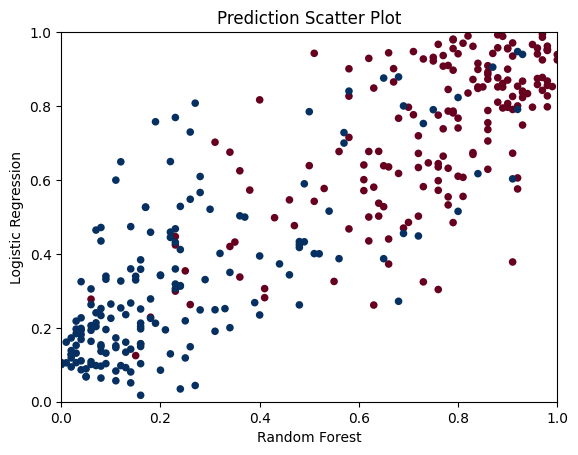

In [102]:
plt.scatter(test_results["Random Forest"], test_results["Logistic Regression"], 30, test_labels, 
            cmap="RdBu_r", edgecolor="none")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Random Forest")
plt.ylabel("Logistic Regression")
plt.title("Prediction Scatter Plot")

['MUCAPE' 'MUMR' '500TEMP' '300 T' '7-5LR' '5-3 LR' '0-3SH' '0-6SH'
 '0-9SH' 'SRH3']


Text(0.5, 1.0, 'Comparative Distributions of MUCAPE')

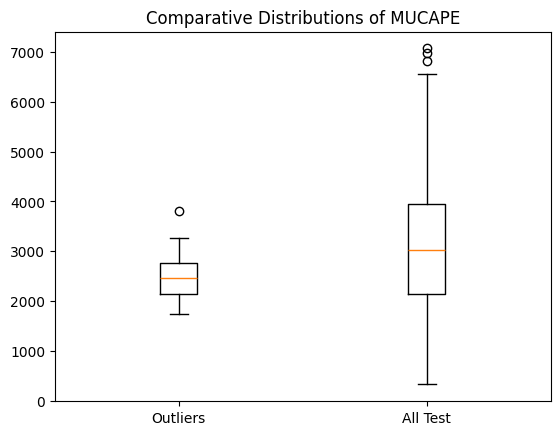

In [103]:
print(input_cols)
test_outliers = test.index[np.where((test_results["Random Forest"] > 0.5) & (test_results["Logistic Regression"] < 0.5))[0]]
box_var = "MUCAPE"
plt.boxplot([test.loc[test_outliers, box_var], test.loc[:, box_var]])
plt.xticks([1,2], ["Outliers", "All Test"])
plt.title("Comparative Distributions of " + box_var)

# Regression Models
* Predict most likely hail size based on input parameters
* Random Forest: Leaf nodes contain mean of training sample labels
* Gradient Boosting: Stagewise ensemble of decision trees

In [107]:
reg_models = [RandomForestRegressor(n_estimators=500), 
              Lasso(alpha=0.5), 
              GradientBoostingRegressor(loss="squared_error", n_estimators=300, learning_rate=0.1, max_depth=5)]
reg_model_names = ["Random Forest", "Lasso", "Gradient Boosting"]
for reg_model in reg_models:
    reg_model.fit(train[input_cols], train[test_col])

(0.0, 6.0)

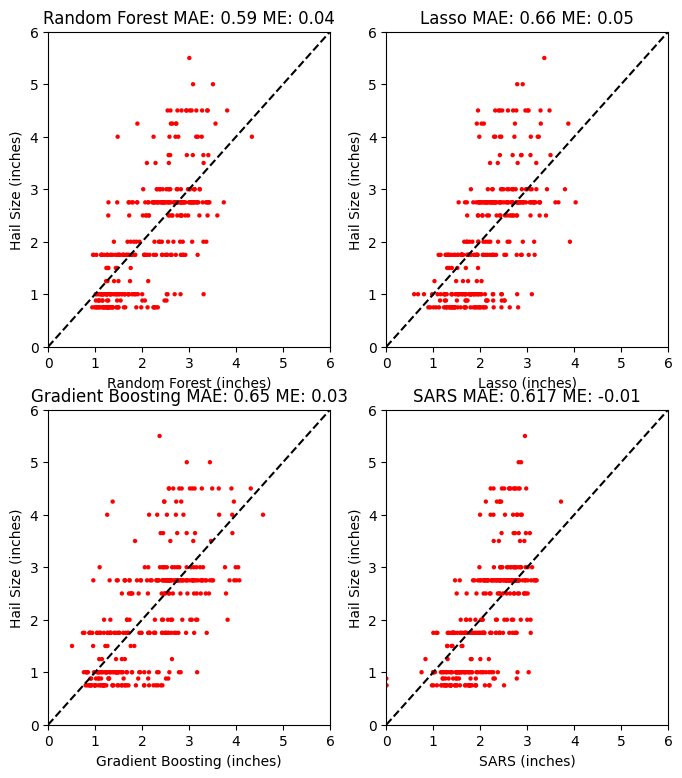

In [110]:
fig, axs = plt.subplots(2, 2, figsize=(8, 9))
for a, ax in enumerate(axs.ravel()[:-1]):
    preds = reg_models[a].predict(test[input_cols])
    error = np.mean(np.abs(preds - test[test_col].values))
    me = np.mean(preds - test[test_col].values)
    ax.scatter(preds, test[test_col], 10, 'r', edgecolor="none")
    ax.plot(np.arange(0, 7), np.arange(0, 7), 'k--')
    ax.set_title(reg_model_names[a] + " MAE: {0:0.2f} ME: {1:0.2f}".format(error, me))
    ax.set_xlabel(reg_model_names[a] + " (inches)")
    ax.set_ylabel("Hail Size (inches)")
    ax.set_xlim(0, 6)
    ax.set_ylim(0, 6)

ax = axs.ravel()[-1]
preds = sars_hail_sizes
error = np.mean(np.abs(preds - test[test_col].values))
me = np.mean(preds - test[test_col].values)
ax.scatter(sars_hail_sizes, test[test_col], 10, 'r', edgecolor="none")
ax.plot(np.arange(0, 7), np.arange(0, 7), 'k--')
ax.set_title("SARS" + " MAE: {0:0.3f} ME: {1:0.2f}".format(error, me))
ax.set_xlabel("SARS" + " (inches)")
ax.set_ylabel("Hail Size (inches)")
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

# Issues with Predicting Hail Size through Regression
* Underestimation of very large hail
* Error of ~0.6 inches on average
* Larger error variance with increasing hail size

Text(0.5, 1.0, 'Gradient Boosting Feature Importance Scores')

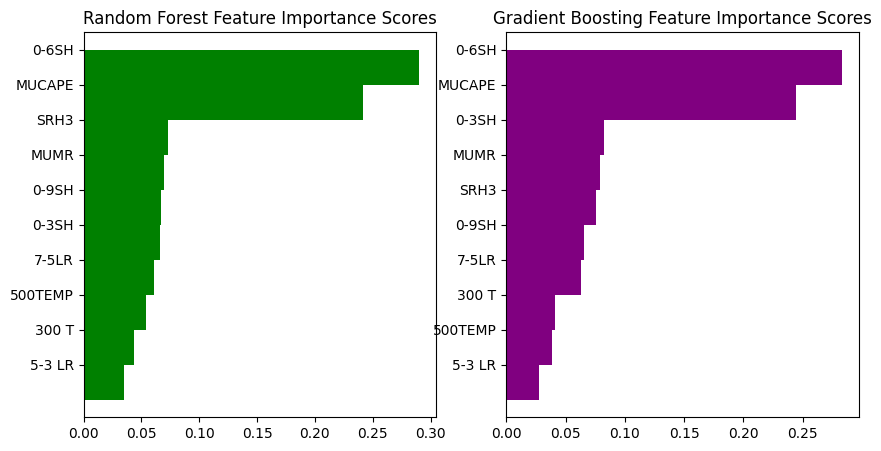

In [111]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
feature_ranking = reg_models[0].feature_importances_.argsort()
plt.barh(np.arange(feature_ranking.size), reg_models[0].feature_importances_[feature_ranking], 1, color="green")
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[feature_ranking])
plt.title("Random Forest Feature Importance Scores")

plt.subplot(1, 2, 2)
feature_ranking = reg_models[2].feature_importances_.argsort()
plt.barh(np.arange(feature_ranking.size), reg_models[2].feature_importances_[feature_ranking], 1, color="purple")
plt.yticks(np.arange(feature_ranking.size) + 0.5, input_cols[feature_ranking])
plt.title("Gradient Boosting Feature Importance Scores")

# Feature Importance Issues
* Different rankings depending on model type and model configuration
* Correlated variables share importance because model will choose one or other based on resampled training data
* Shared importance decreases score and rankings for correlated variables

In [170]:
cols = ["MUCAPE", "0-6SH"]
hail_thresh = 2
hail_labels = np.where(train[test_col] >= hail_thresh, 1, 0)
col_means = train[cols].mean()
col_sds = train[cols].std()
train_norm = (train[cols] - col_means) / col_sds

dt_simple = DecisionTreeClassifier(max_depth=3)
dt_simple.fit(train[cols], hail_labels)

rf_simple = RandomForestClassifier(n_estimators=100, max_depth=3)
rf_simple.fit(train[cols], hail_labels)

lr_simple = LogisticRegression(C=1)
lr_simple.fit(train[cols], hail_labels)

gb = HistGradientBoostingClassifier(max_depth=3)
gb.fit(train[cols], hail_labels)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_norm, hail_labels)

cape_values = np.linspace(0, 8000, 500)
shear_values = np.linspace(0, 50, 400)
cape_grid, shear_grid = np.meshgrid(cape_values, shear_values)
data_grid = pd.DataFrame(np.vstack([cape_grid.ravel(), shear_grid.ravel()]).T, columns=cols)
data_grid_norm = pd.DataFrame(np.vstack([(cape_grid.ravel() - col_means.iloc[0]) / col_sds.iloc[0], 
                       (shear_grid.ravel() - col_means.iloc[1]) / col_sds.iloc[1]]).T, columns=cols)

rf_preds = rf_simple.predict_proba(data_grid)[:, 1]
rf_pred_grid = rf_preds.reshape(cape_grid.shape)
dt_preds = dt_simple.predict_proba(data_grid)[:, 1]
dt_pred_grid = dt_preds.reshape(cape_grid.shape)
lr_preds = lr_simple.predict_proba(data_grid)[:, 1]
lr_pred_grid = lr_preds.reshape(cape_grid.shape)
knn_preds = knn.predict_proba(data_grid_norm)[:, 1]
knn_pred_grid = knn_preds.reshape(cape_grid.shape)
gb_preds = gb.predict_proba(data_grid)[:, 1]
gb_pred_grid = gb_preds.reshape(cape_grid.shape)

In [162]:
dts = [] 
dt_grids = []
for depth in range(1, 8):
    dts.append(DecisionTreeClassifier(max_depth=depth))
    dts[-1].fit(train[cols], hail_labels)
    dt_preds = dts[-1].predict_proba(data_grid)[:, 1]
    dt_grids.append(dt_preds.reshape(cape_grid.shape))

In [163]:
rfs = [] 
rf_grids = []
for depth in range(1, 8):
    rfs.append(RandomForestClassifier(n_estimators=100, max_features=1, max_depth=depth))
    rfs[-1].fit(train[cols], hail_labels)
    rf_preds = rfs[-1].predict_proba(data_grid)[:, 1]
    rf_grids.append(rf_preds.reshape(cape_grid.shape))

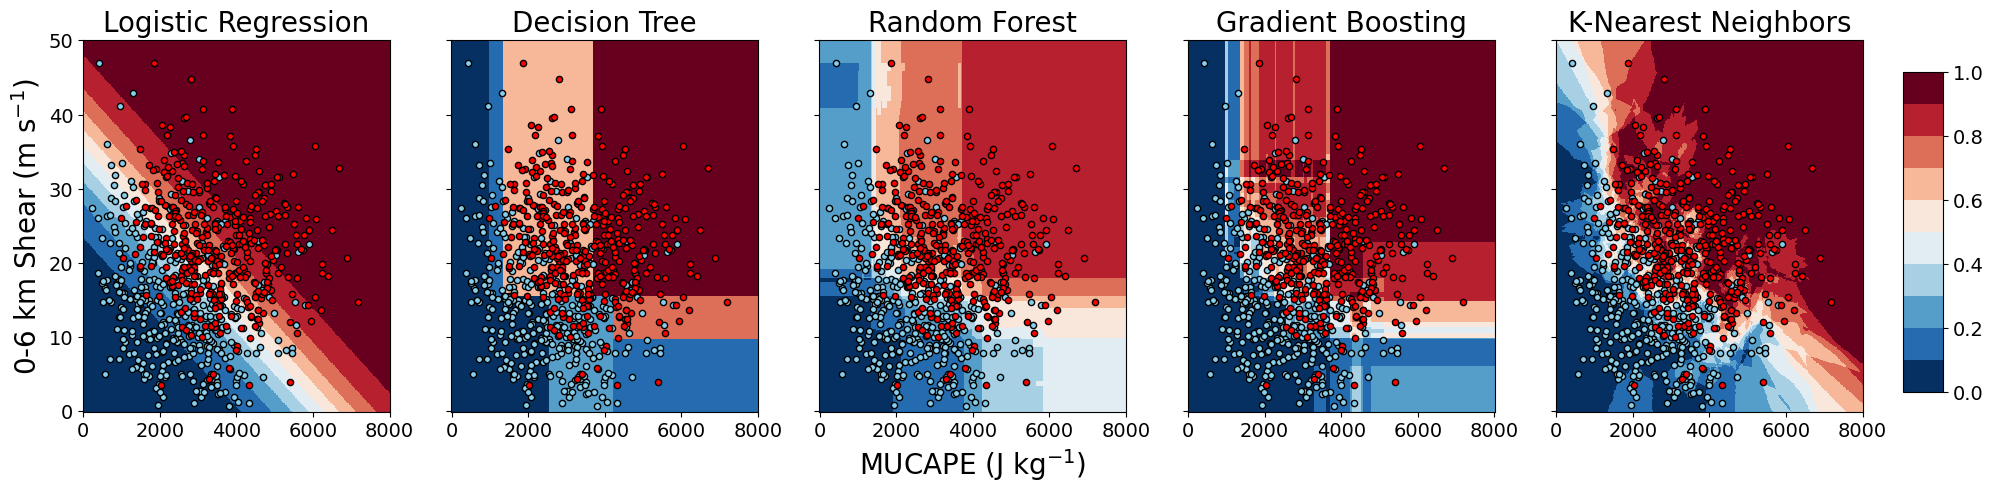

In [171]:
pred_grids = [lr_pred_grid, dt_pred_grid, rf_pred_grid, gb_pred_grid, knn_pred_grid]
titles = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting", "K-Nearest Neighbors"]
n_grids = len(pred_grids)
height = 4
fig, axes = plt.subplots(1, n_grids, figsize=(height * n_grids, height), sharey=True)
cax = fig.add_axes([0.96, 0.1, 0.02, 0.8])
plt.subplots_adjust(0.05, 0.05, 0.94, 0.98)
for i in range(n_grids):
    pm = axes[i].pcolormesh(cape_values, shear_values, pred_grids[i], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1)
    plt.setp(axes[i].get_xticklabels(), fontsize=14)
    axes[i].set_title(titles[i], fontsize=20)
for i in range(n_grids):
    axes[i].scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 20, "skyblue", ec="k", label="Hail < 2 inches")
    axes[i].scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 20, "red", ec="k", label="Hail > 2 inches")
cbar = plt.colorbar(pm, cax)
plt.setp(cax.get_yticklabels(), fontsize=14)
plt.setp(axes[0].get_yticklabels(), fontsize=14)
axes[n_grids // 2].set_xlabel("MUCAPE (J kg$^{-1}$)", fontsize=20)
axes[0].set_ylabel("0-6 km Shear (m s$^{-1}$)", fontsize=20)
plt.savefig("feature_space.png", dpi=300, bbox_inches="tight")

Text(0, 0.5, 'Wind Shear')

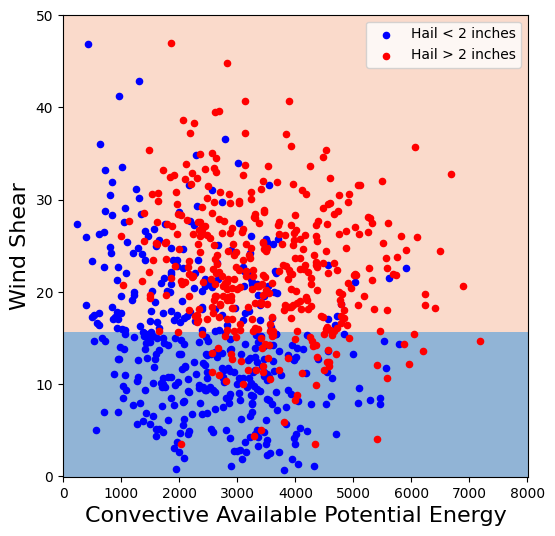

In [120]:
plt.figure(figsize=(6, 6))
plt.pcolormesh(cape_values, shear_values, dt_grids[0], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1, alpha=0.5)
plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 20, "blue", label="Hail < 2 inches")

plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 20, "red", label="Hail > 2 inches")
plt.legend()
plt.xlabel("Convective Available Potential Energy", fontsize=16)
plt.ylabel("Wind Shear", fontsize=16)

Text(0, 0.5, 'Wind Shear')

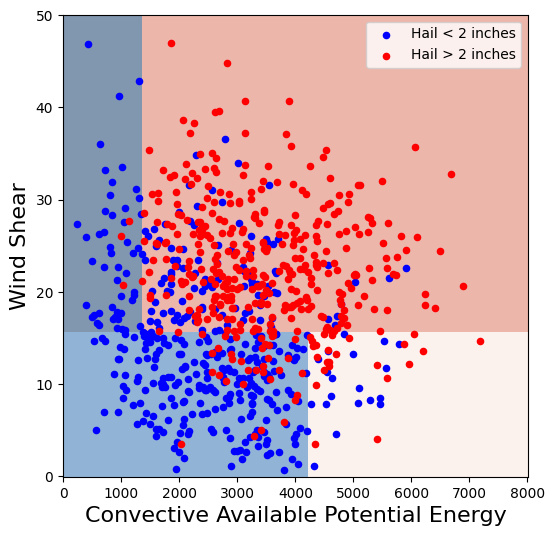

In [121]:
plt.figure(figsize=(6, 6))
plt.pcolormesh(cape_values, shear_values, dt_grids[1], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1, alpha=0.5)
plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 20, "blue", label="Hail < 2 inches")

plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 20, "red", label="Hail > 2 inches")
plt.legend()
plt.xlabel("Convective Available Potential Energy", fontsize=16)
plt.ylabel("Wind Shear", fontsize=16)

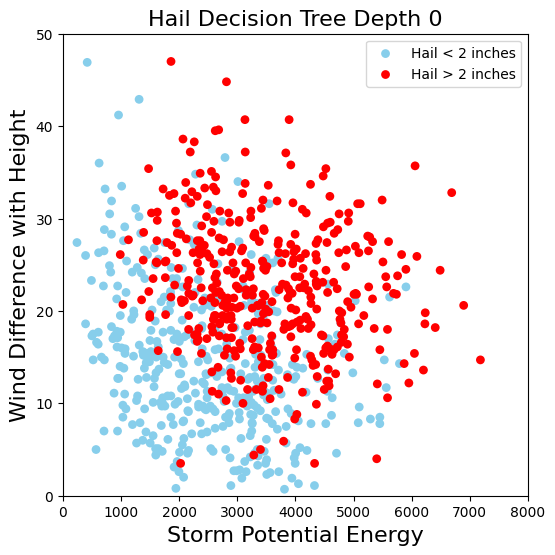

In [124]:
plt.figure(figsize=(6, 6))
#plt.pcolormesh(cape_values, shear_values, dt_grids[depth_model], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1, alpha=0.5)
plt.gca().set_background
plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 40, "skyblue", ec="k", label="Hail < 2 inches")

plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 40, "red", ec="k", label="Hail > 2 inches")
plt.legend()
plt.xlabel("Storm Potential Energy", fontsize=16)
plt.title(f"Hail Decision Tree Depth 0", fontsize=16)
plt.ylabel("Wind Difference with Height", fontsize=16)
plt.xlim(0, 8000)
plt.ylim(0, 50)
plt.savefig("hail_dt_0.png", dpi=150, bbox_inches="tight")

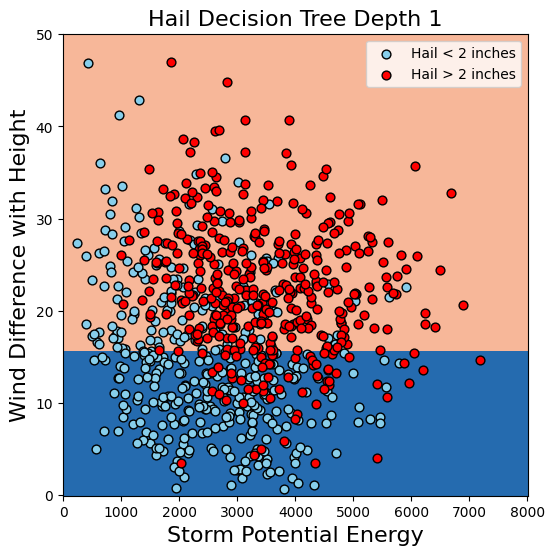

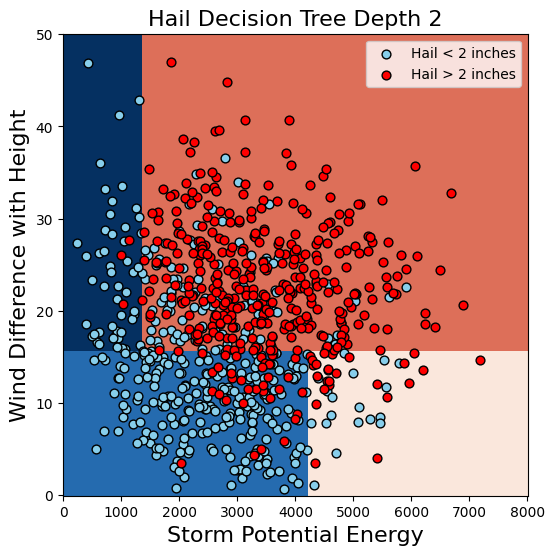

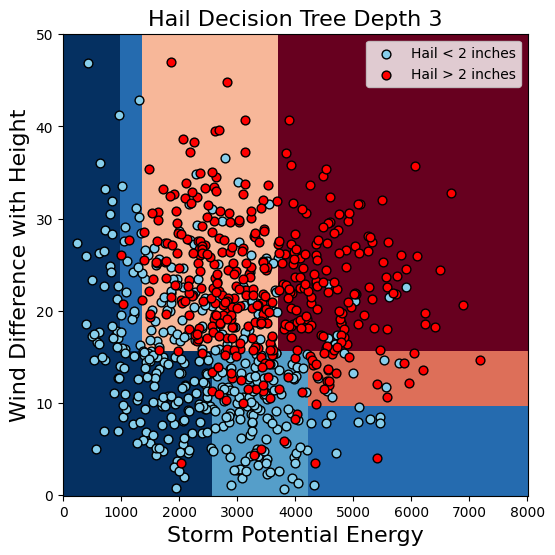

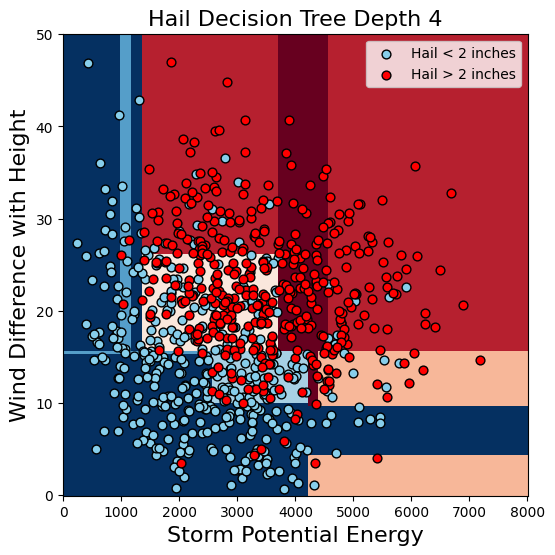

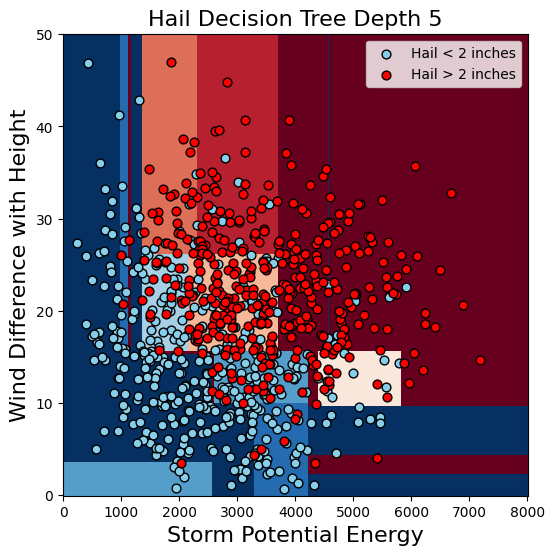

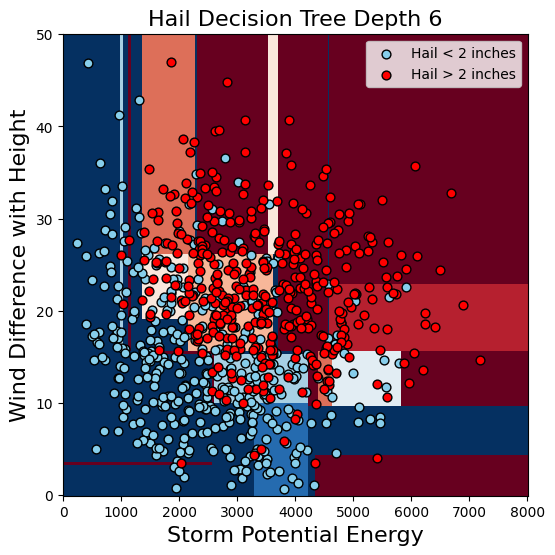

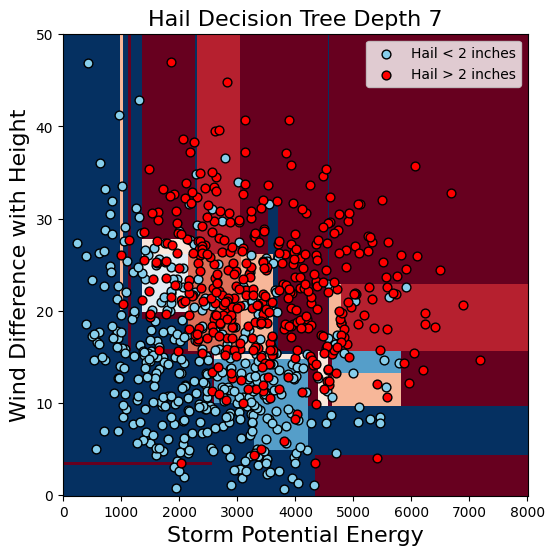

In [123]:
for depth_model in range(7):
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(cape_values, shear_values, dt_grids[depth_model], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1)
    plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 40, "skyblue", ec="k", label="Hail < 2 inches")

    plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 40, "red", ec="k", label="Hail > 2 inches")
    plt.legend()
    plt.xlabel("Storm Potential Energy", fontsize=16)
    plt.title(f"Hail Decision Tree Depth {depth_model+1:d}", fontsize=16)
    plt.ylabel("Wind Difference with Height", fontsize=16)
    plt.savefig(f"hail_dt_{depth_model+1:d}.png", dpi=150, bbox_inches="tight")

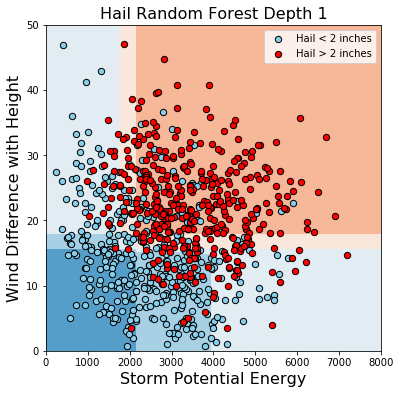

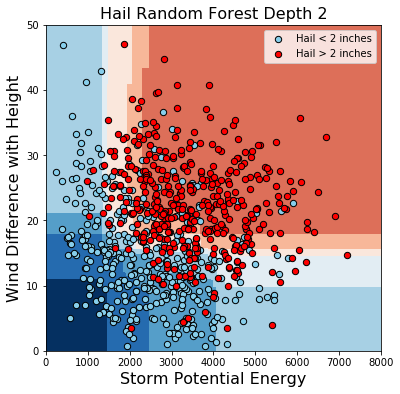

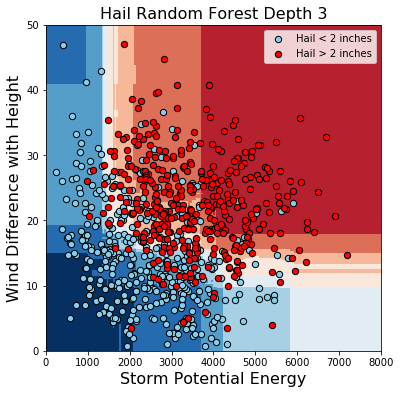

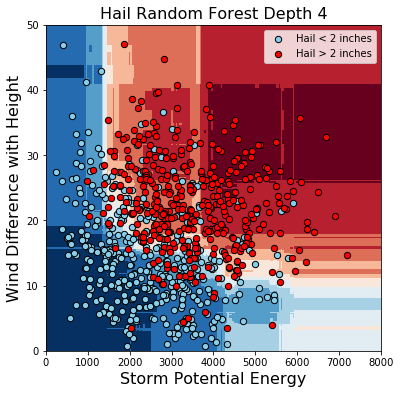

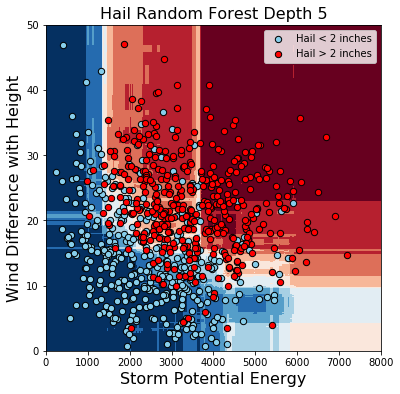

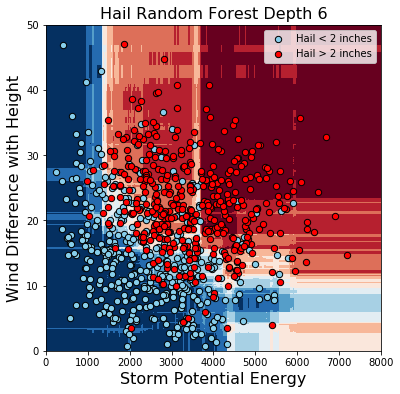

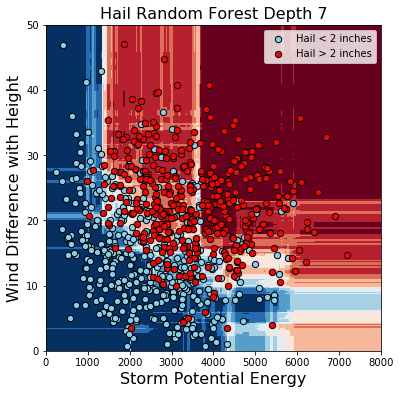

In [108]:
for depth_model in range(7):
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(cape_values, shear_values, rf_grids[depth_model], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1)
    plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 40, "skyblue", ec="k", label="Hail < 2 inches")

    plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 40, "red", ec="k", label="Hail > 2 inches")
    plt.legend()
    plt.xlabel("Storm Potential Energy", fontsize=16)
    plt.title(f"Hail Random Forest Depth {depth_model+1:d}", fontsize=16)
    plt.ylabel("Wind Difference with Height", fontsize=16)
    plt.savefig(f"hail_rf_{depth_model+1:d}.png", dpi=150, bbox_inches="tight")

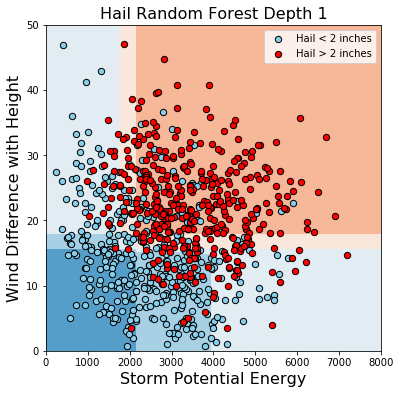

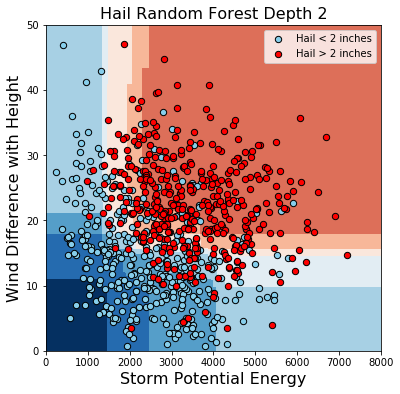

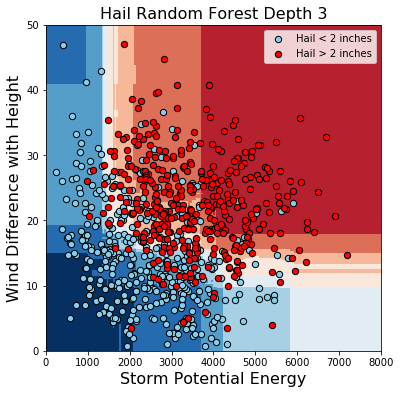

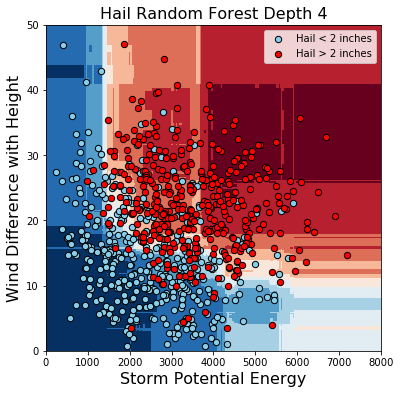

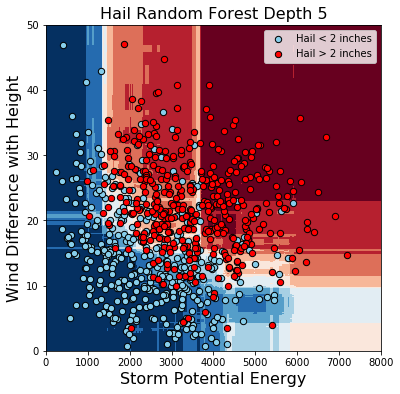

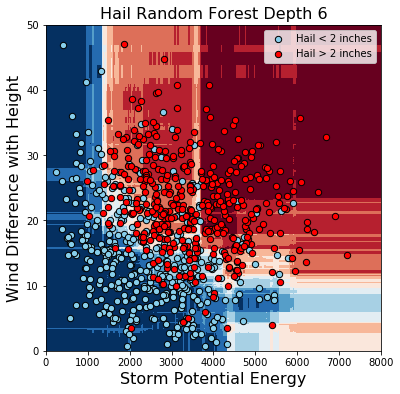

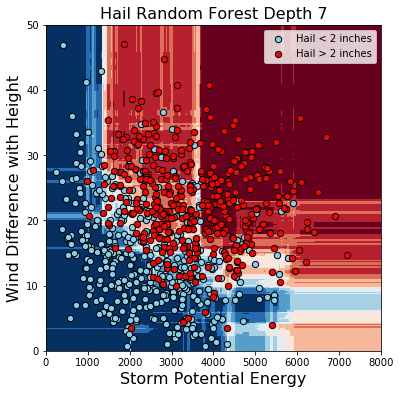

In [108]:
for depth_model in range(7):
    plt.figure(figsize=(6, 6))
    plt.pcolormesh(cape_values, shear_values, rf_grids[depth_model], cmap=plt.get_cmap("RdBu_r", 10), vmin=0, vmax=1)
    plt.scatter(train["MUCAPE"][train[test_col] < 2], train["0-6SH"][train[test_col] < 2], 40, "skyblue", ec="k", label="Hail < 2 inches")

    plt.scatter(train["MUCAPE"][train[test_col] >= 2], train["0-6SH"][train[test_col] >= 2], 40, "red", ec="k", label="Hail > 2 inches")
    plt.legend()
    plt.xlabel("Storm Potential Energy", fontsize=16)
    plt.title(f"Hail Random Forest Depth {depth_model+1:d}", fontsize=16)
    plt.ylabel("Wind Difference with Height", fontsize=16)
    plt.savefig(f"hail_rf_{depth_model+1:d}.png", dpi=150, bbox_inches="tight")